## Team 6 [CO-MMA] Final Code

In [ ]:
import os
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import make_pipeline
import dmba
from dmba import classificationSummary

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import arange
from pandas import Series
from pandas import read_csv
from sklearn.cluster import KMeans, Birch
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_selection import SelectFromModel
from numpy import array,unique
from numpy import reshape,where
from sklearn.cluster import Birch
from keras_sequential_ascii import keras2ascii
from ann_visualizer.visualize import ann_viz;
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from numpy import absolute
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error
from typing import Tuple
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from kneed import KneeLocator
from sklearn.cluster import KMeans, Birch
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics
from sklearn.metrics import silhouette_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from yellowbrick.cluster import KElbowVisualizer

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
df_cust = pd.read_parquet("bigdata2021data/cust_train.parquet")
df_transaction = pd.read_parquet("bigdata2021data/transaction_train.parquet")

## Data Preprocessing

In [ ]:
def dataProcessing(df_cust,df_transaction):
    
    ####Transaction Data Preprocessing 
    tran_train_sum=df_transaction.groupby("customer_id_mskd").sum()
    tr_sum = tran_train_sum.rename(columns={"in_amt": "in_amt_sum", "in_cnt": "in_cnt_sum",
                                            "out_amt": "out_amt_sum", "out_cnt": "out_cnt_sum"})

    tran_train_mean=df_transaction.groupby("customer_id_mskd").mean()
    tr_avg = tran_train_mean.rename(columns={"in_amt": "in_amt_avg", "in_cnt": "in_cnt_avg",
                                             "out_amt": "out_amt_avg", "out_cnt": "out_cnt_avg"})

    tran_train_std = df_transaction.groupby("customer_id_mskd").std()
    tr_std = tran_train_std.rename(columns={"in_amt": "in_amt_std", "in_cnt": "in_cnt_std",
                                            "out_amt": "out_amt_std", "out_cnt": "out_cnt_std"})

    tran_train_min= df_transaction.groupby("customer_id_mskd").min()
    tr_min = tran_train_min.rename(columns={"in_amt": "in_amt_min", "in_cnt": "in_cnt_min",
                                            "out_amt": "out_amt_min", "out_cnt": "out_cnt_min"})

    tr_min_1 = tr_min.drop(columns=['month','trsactn_type'])
    tran_train_max= df_transaction.groupby("customer_id_mskd").max()

    tr_max = tran_train_max.rename(columns={"in_amt": "in_amt_max", "in_cnt": "in_cnt_max",
                                            "out_amt": "out_amt_max", "out_cnt": "out_cnt_max"})
    tr_max_1 = tr_max.drop(columns=['month','trsactn_type'])
    
    
    
    tran_train_null_inct_count=pd.DataFrame(df_transaction["customer_id_mskd"]).join(pd.DataFrame(df_transaction["in_cnt"].isna())).groupby("customer_id_mskd").sum().rename(columns={'in_cnt': 'in_cnt_null'})


    tran_train_null_outct_count=pd.DataFrame(df_transaction["customer_id_mskd"]).join(pd.DataFrame(df_transaction["out_cnt"].isna())).groupby("customer_id_mskd").sum().rename(columns={'out_cnt': 'out_cnt_null'})
    
    tran_train=df_transaction
    tran_train_transtype_count=tran_train.groupby("customer_id_mskd").nunique()
    del tran_train_transtype_count['customer_id_mskd']
    tran_train_transtype_count = tran_train_transtype_count.drop(columns=['month',"in_amt","out_amt","in_cnt","out_cnt"])
    tran_train_transtype_count = tran_train_transtype_count.rename(columns={'trsactn_type': 'trsactn_type_count'})


    tran_train_count_trsactn_type=tran_train.groupby(['customer_id_mskd','trsactn_type']).size().reset_index().rename(
        columns = {0:'counting'}).groupby(['customer_id_mskd',
                                           'trsactn_type'])['counting'].aggregate('first').unstack().fillna(0)
    
    
    df_1 = pd.merge(df_cust,tr_sum,how='left',on='customer_id_mskd')
    df_2 = pd.merge(df_1,tr_avg,how='left',on='customer_id_mskd')
    df_3 = pd.merge(df_2,tr_std,how='left',on='customer_id_mskd')
    df_4 = pd.merge(df_3,tr_min_1,how='left',on='customer_id_mskd')
    df_5 = pd.merge(df_4,tr_max_1,how='left',on='customer_id_mskd')
    df_6 = pd.merge(df_5,tran_train_null_inct_count,how='left',on='customer_id_mskd')
    df_7 = pd.merge(df_6,tran_train_null_outct_count,how='left',on='customer_id_mskd')
    df_8 = pd.merge(df_7,tran_train_transtype_count,how='left',on='customer_id_mskd')
    df_9 = pd.merge(df_8,tran_train_count_trsactn_type,how='left',on='customer_id_mskd')

    df=df_9.copy()
    
   
    
     ###Customer Pre-processing
    df.drop(columns=['client_type_aml'],inplace=True)
    df.drop(columns=['industry_code_aml'],inplace=True)
    df.drop(columns=['export_ts'],inplace=True)
    df.drop(columns=['PRD_INFO_AVAIL'],inplace=True)
    df.drop(columns=['occupation_status_code_aml'],inplace=True)
    df.drop(columns=['SRV_FLG','SRV_FSL','SRV_ILC','SRV_LOC','SRV_NLG','SRV_NSL','SRV_TRF'],inplace=True)
    
    df.loc[(df['customer_status_aml'] != 'Active') 
              , 'customer_status_aml'] = 'Others' 
    
    df.loc[(df['jurisdiction_code'] != 'CA03') 
              , 'jurisdiction_code'] = 'Others' 
    

    df.loc[((df['relationship_type'] != ' Sole') &
           (df['relationship_type'] != 'Owner') &
           (df['relationship_type'] != 'Borrower') &
           (df['relationship_type'] != 'Co-Borrower') &
           (df['relationship_type'] != 'Joint') &
           (df['relationship_type'] != 'Primary Joint') &
           (df['relationship_type'] != 'Annuitant') &
           (df['relationship_type'] != 'Primary Joint') &
           (df['relationship_type'] != 'Supplemental cardholder') &
           (df['relationship_type'] != 'Co-signor'))
           , 'relationship_type'] = 'Others' 

    
    df['occupation_code_aml'].fillna('E901',inplace = True)
    df.loc[((df['occupation_code_aml'] != 'E901') &
           (df['occupation_code_aml'] != 'E902') &
           (df['occupation_code_aml'] != 'E904'))
           , 'occupation_code_aml'] = 'Employed/Others' 

    occMap = {'E901':'Unemployed','E902':'Retired','E904':'Self-employed','Employed/Others':'Employed/Others'}
    df['occupation_code_aml']=df['occupation_code_aml'].map(occMap)
    
    
    df['primary_ownership_flag'].fillna('N',inplace = True)
    
    df_new = df['country_of_domicile_aml'].replace({'CA':1}, inplace=True)
    df["country_of_domicile_aml"]= np.where(df["country_of_domicile_aml"]=='CA',1,0)
    
    df["in_cnt_null"].replace(False, 0, inplace=True)
    df["out_cnt_null"].replace(False, 0, inplace=True)
    
    
    # categorical variables - Indicator
    for i in range(len(df.columns)):
        df[df.columns[i]].replace({np.nan: 0}, inplace=True)

    df = pd.get_dummies(df, 
                        prefix=['j','c', 'o', 'csa','pof','rt'], 
                        columns=['jurisdiction_code', 'country_of_domicile_aml',
                                 'occupation_code_aml', 'customer_status_aml',
                                 'primary_ownership_flag', 'relationship_type',])



    return df

In [ ]:
df=dataProcessing(df_cust, df_transaction)

In [ ]:
df.head()

,customer_id_mskd,PCD_CDA,PCD_CMS,PCD_CRC,PCD_LLC,PCD_MOR,PCD_MUF,PCD_SAV,PCD_SDB,PCD_TED,rating,in_amt_sum,in_cnt_sum,out_amt_sum,out_cnt_sum,in_amt_avg,in_cnt_avg,out_amt_avg,out_cnt_avg,in_amt_std,in_cnt_std,out_amt_std,out_cnt_std,in_amt_min,in_cnt_min,out_amt_min,out_cnt_min,in_amt_max,in_cnt_max,out_amt_max,out_cnt_max,in_cnt_null,out_cnt_null,trsactn_type_count,amex,cash,cheque,debit,visa,j_CA03,j_Others,c_0,o_Employed/Others,o_Retired,o_Self-employed,o_Unemployed,csa_Active,csa_Others,pof_N,pof_Y,rt_Annuitant,rt_Borrower,rt_Co-Borrower,rt_Co-signor,rt_Joint,rt_Others,rt_Owner,rt_Primary Joint
0,df39588796bc20fb01d282213200c944ad38caa06a91a7...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,47884.28,127.0,57053.62,617.0,2816.722353,7.470588,1462.913333,15.820513,2071.229031,4.302872,1912.801055,22.320479,170.0,1.0,2.11,1.0,6862.54,14.0,6282.50,67.0,23.0,1.0,4.0,0.0,10.0,6.0,11.0,13.0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
1,d56f5632aa40d2661dcc5419def6ede2ed4cca24bd76cd...,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,197850.44,34.0,140360.36,289.0,12365.652500,2.125000,3598.983590,7.410256,21738.433399,0.957427,10075.856244,6.800611,410.0,1.0,80.00,1.0,67000.00,4.0,53813.81,24.0,23.0,0.0,3.0,0.0,0.0,13.0,13.0,13.0,1,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0
2,a86efc98b6e70bbb37c12024304f3d7c9eac9e4ecd9559...,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,3.0,61087.87,63.0,136307.92,859.0,2655.994348,2.739130,2672.704314,16.843137,2369.653663,1.912100,2177.988412,18.332891,19.9,1.0,60.00,1.0,8619.19,7.0,13361.32,64.0,28.0,0.0,4.0,0.0,13.0,12.0,13.0,13.0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0
3,24f154d9bb05a18ba723830b6c41d6eb71a67f14ca7325...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,2978.48,17.0,0.00,0.0,248.206667,1.416667,0.000000,0.000000,570.059784,0.668558,0.000000,0.000000,15.0,1.0,0.00,0.0,2046.33,3.0,0.00,0.0,0.0,12.0,3.0,0.0,4.0,5.0,3.0,0.0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
4,bdb58c996ed0b5c9f81461caa8efe914f712e22ffaa6ac...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4469 entries, 0 to 4468
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id_mskd    4469 non-null   object 
 1   PCD_CDA             4469 non-null   float64
 2   PCD_CMS             4469 non-null   float64
 3   PCD_CRC             4469 non-null   float64
 4   PCD_LLC             4469 non-null   float64
 5   PCD_MOR             4469 non-null   float64
 6   PCD_MUF             4469 non-null   float64
 7   PCD_SAV             4469 non-null   float64
 8   PCD_SDB             4469 non-null   float64
 9   PCD_TED             4469 non-null   float64
 10  rating              4469 non-null   float64
 11  in_amt_sum          4469 non-null   float64
 12  in_cnt_sum          4469 non-null   float64
 13  out_amt_sum         4469 non-null   float64
 14  out_cnt_sum         4469 non-null   float64
 15  in_amt_avg          4469 non-null   float64
 16  in_cnt

# EDA
## Customer Data

In [ ]:
def crosstab_analysis(df, predictor1, predictor2):
    
    ax= pd.crosstab(df[predictor1], df[predictor2]).apply(lambda r: r/r.sum()*100, axis=1)
    ax_1 = ax.plot.bar(figsize=(10,10),stacked=True, rot=30)

    plt.legend(loc='lower center', bbox_to_anchor=(0.1, 1.0), title="Subject")
    plt.title(predictor1+' '+predictor2 +' plot')
    if predictor2 == 'rating':
        plt.ylabel('y')
    else:
        plt.ylabel(predictor2)

    for rec in ax_1.patches:
        height = rec.get_height()
        ax_1.text(rec.get_x() + rec.get_width() / 2, rec.get_y() + height / 2,"{:.0f}%".format(height),
                ha='center', va='bottom')

    plt.savefig(predictor1+' '+predictor2 +' plot.png', dpi=300, bbox_inches='tight')
    plt.show()
    return
    
def corrMap(df):
    
    # Compute the correlation matrix
    corr = df.corr()
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    mask = np.zeros(corr.shape, dtype=bool)
    mask[np.triu_indices(len(mask))] = True
    sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, cmap = cmap, annot = True, mask = mask)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    plt.savefig('Correlation Heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    return


In [ ]:
#data processing for EDA only 
def dataProcessing_s(df_cust):
    df = df_cust.copy()
    df.drop(columns=['client_type_aml'],inplace=True)
    df.drop(columns=['industry_code_aml'],inplace=True)
    df.drop(columns=['export_ts'],inplace=True)
    df.drop(columns=['PRD_INFO_AVAIL'],inplace=True)
    df.drop(columns=['occupation_status_code_aml'],inplace=True)
    df.drop(columns=['SRV_FLG','SRV_FSL','SRV_ILC','SRV_LOC','SRV_NLG','SRV_NSL','SRV_TRF'],inplace=True)
    
    df.loc[(df['customer_status_aml'] != 'Active') 
              , 'customer_status_aml'] = 'Others' 
    
    df.loc[(df['jurisdiction_code'] != 'CA03') 
              , 'jurisdiction_code'] = 'Others' 
    

    df.loc[((df['relationship_type'] != ' Sole') &
           (df['relationship_type'] != 'Owner') &
           (df['relationship_type'] != 'Borrower') &
           (df['relationship_type'] != 'Co-Borrower') &
           (df['relationship_type'] != 'Joint') &
           (df['relationship_type'] != 'Primary Joint') &
           (df['relationship_type'] != 'Annuitant') &
           (df['relationship_type'] != 'Primary Joint') &
           (df['relationship_type'] != 'Supplemental cardholder') &
           (df['relationship_type'] != 'Co-signor'))
           , 'relationship_type'] = 'Others' 

    
    df['occupation_code_aml'].fillna('E901',inplace = True)
    df.loc[((df['occupation_code_aml'] != 'E901') &
           (df['occupation_code_aml'] != 'E902') &
           (df['occupation_code_aml'] != 'E904'))
           , 'occupation_code_aml'] = 'Employed/Others' 

    occMap = {'E901':'Unemployed','E902':'Retired','E904':'Self-employed','Employed/Others':'Employed/Others'}
    df['occupation_code_aml']=df['occupation_code_aml'].map(occMap)
    
    
    df['primary_ownership_flag'].fillna('N',inplace = True)
    
    
    df.loc[(df['country_of_domicile_aml'] != 'CA') 
           , 'country_of_domicile_aml'] = 'Others' 
    
    return df

In [ ]:
eda_cust_df =dataProcessing_s(df_cust)

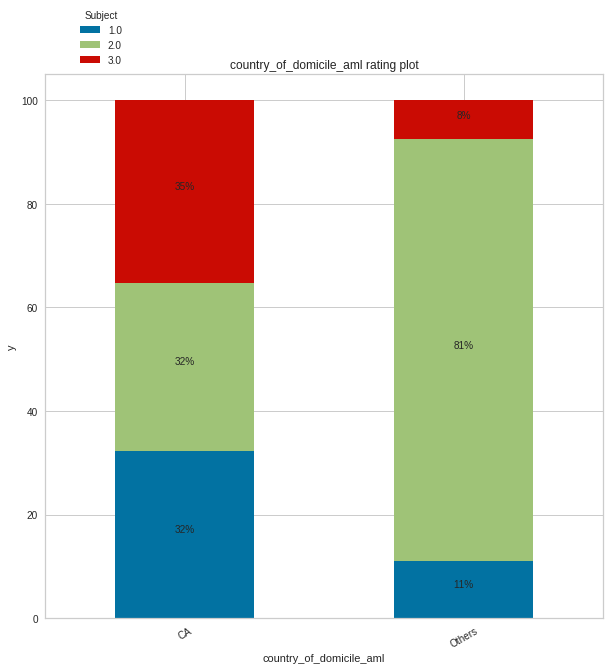

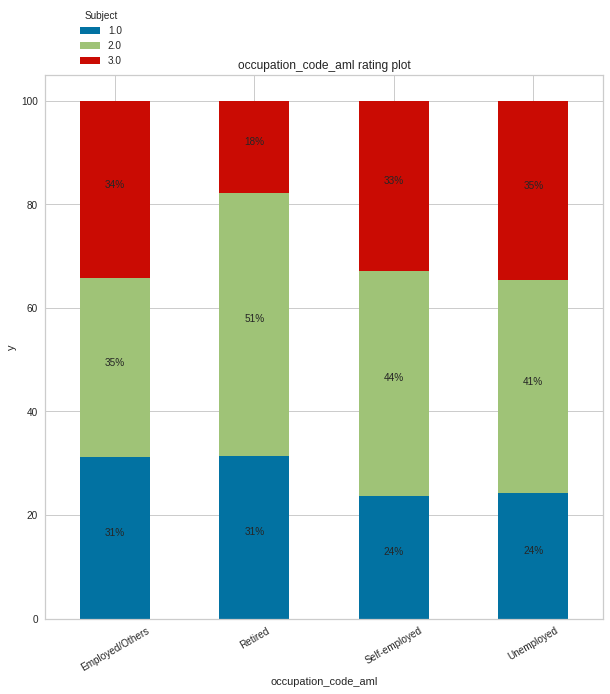

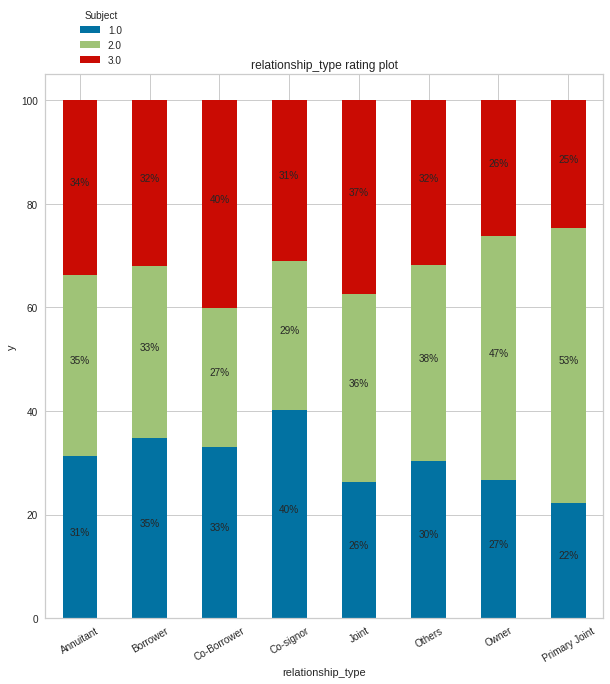

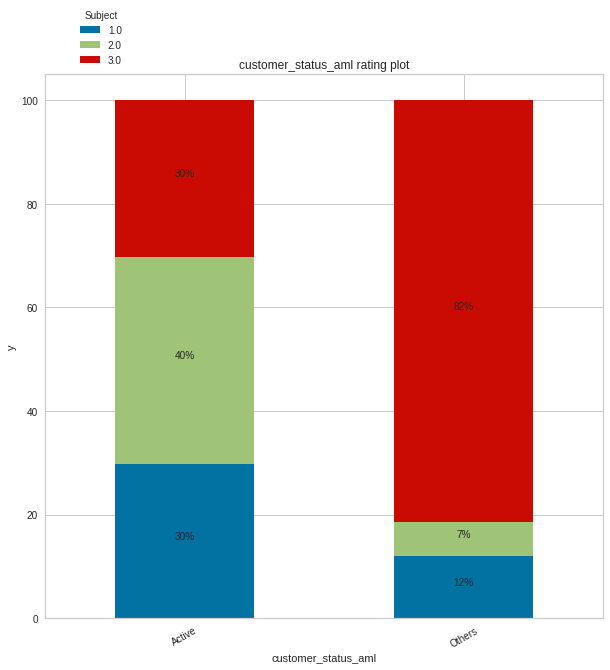

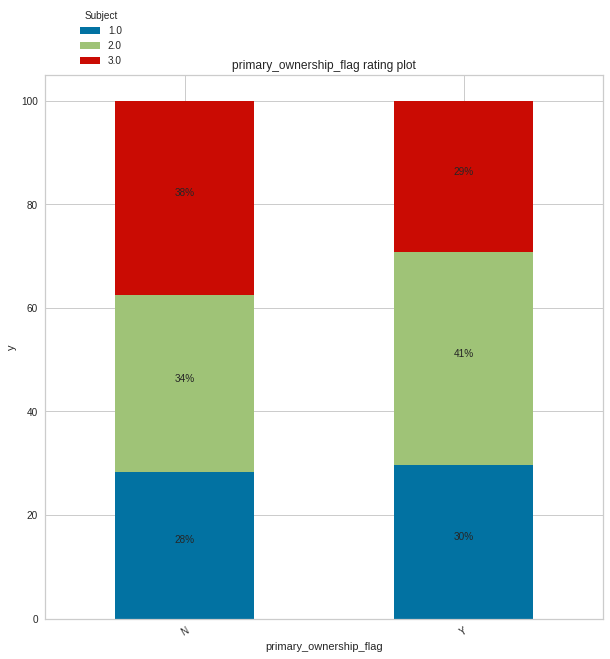

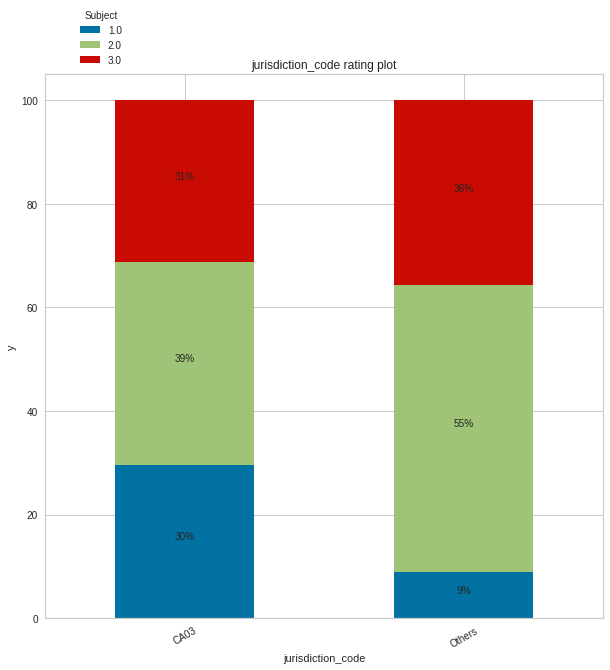

In [ ]:
#crosstab against rating
crosstab_analysis(eda_cust_df,'country_of_domicile_aml','rating')
crosstab_analysis(eda_cust_df,'occupation_code_aml','rating')
crosstab_analysis(eda_cust_df,'relationship_type','rating')
crosstab_analysis(eda_cust_df,'customer_status_aml','rating')
crosstab_analysis(eda_cust_df,'primary_ownership_flag','rating')
crosstab_analysis(eda_cust_df,'jurisdiction_code','rating')

<AxesSubplot:ylabel='client_type_aml'>

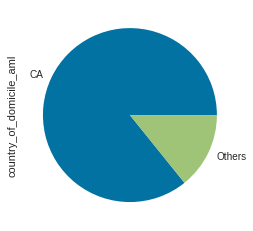

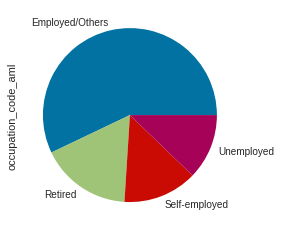

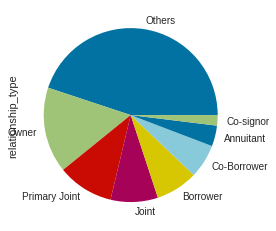

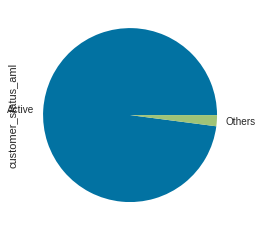

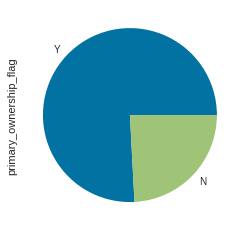

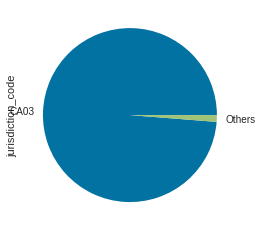

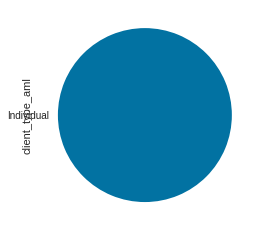

In [ ]:
plt.figure()
eda_cust_df.country_of_domicile_aml.value_counts().plot.pie()
plt.figure()
eda_cust_df.occupation_code_aml.value_counts().plot.pie()
plt.figure()
eda_cust_df.relationship_type.value_counts().plot.pie()
plt.figure()
eda_cust_df.customer_status_aml.value_counts().plot.pie()
plt.figure()
eda_cust_df.primary_ownership_flag.value_counts().plot.pie()
plt.figure()
eda_cust_df.jurisdiction_code.value_counts().plot.pie()
plt.figure()
df_cust.client_type_aml.value_counts().plot.pie()

## Transaction Data EDA

Text(0, 0.5, 'out_amt')

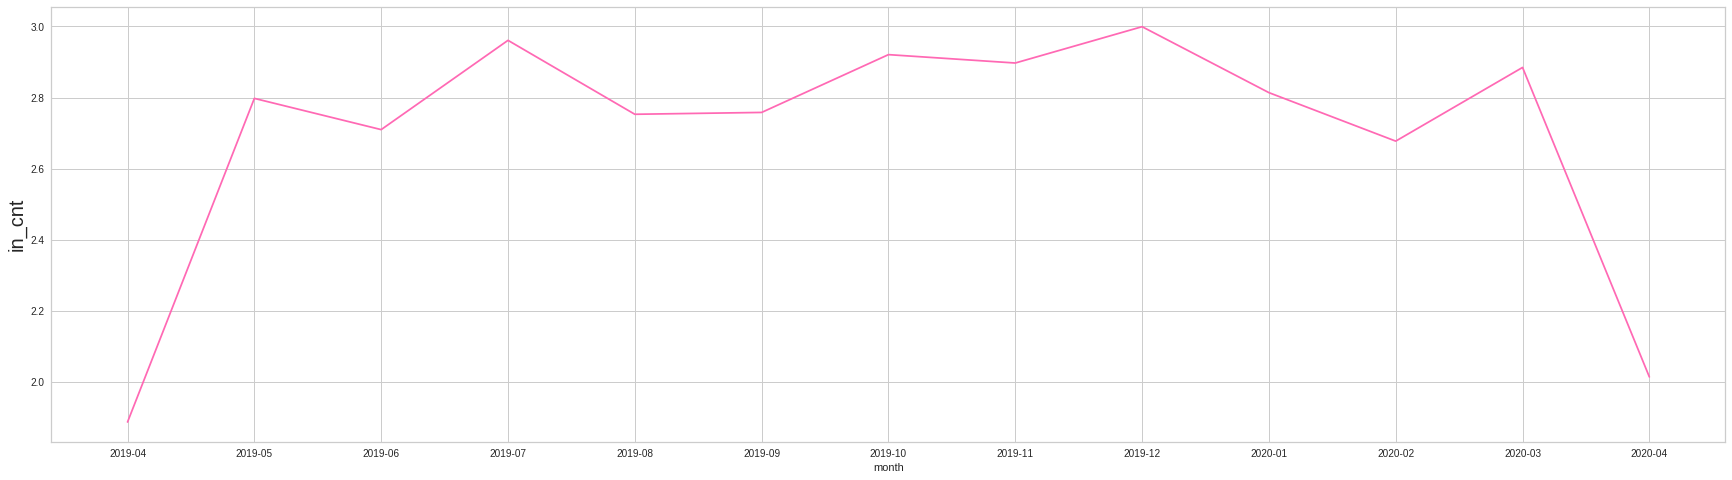

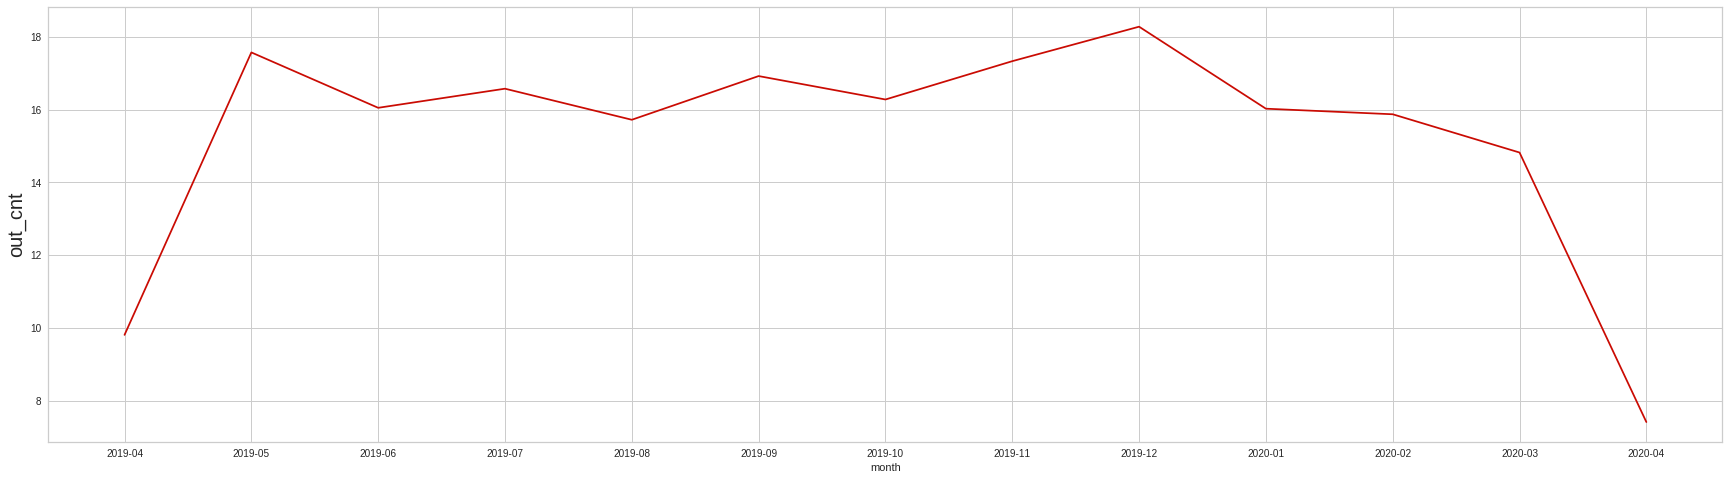

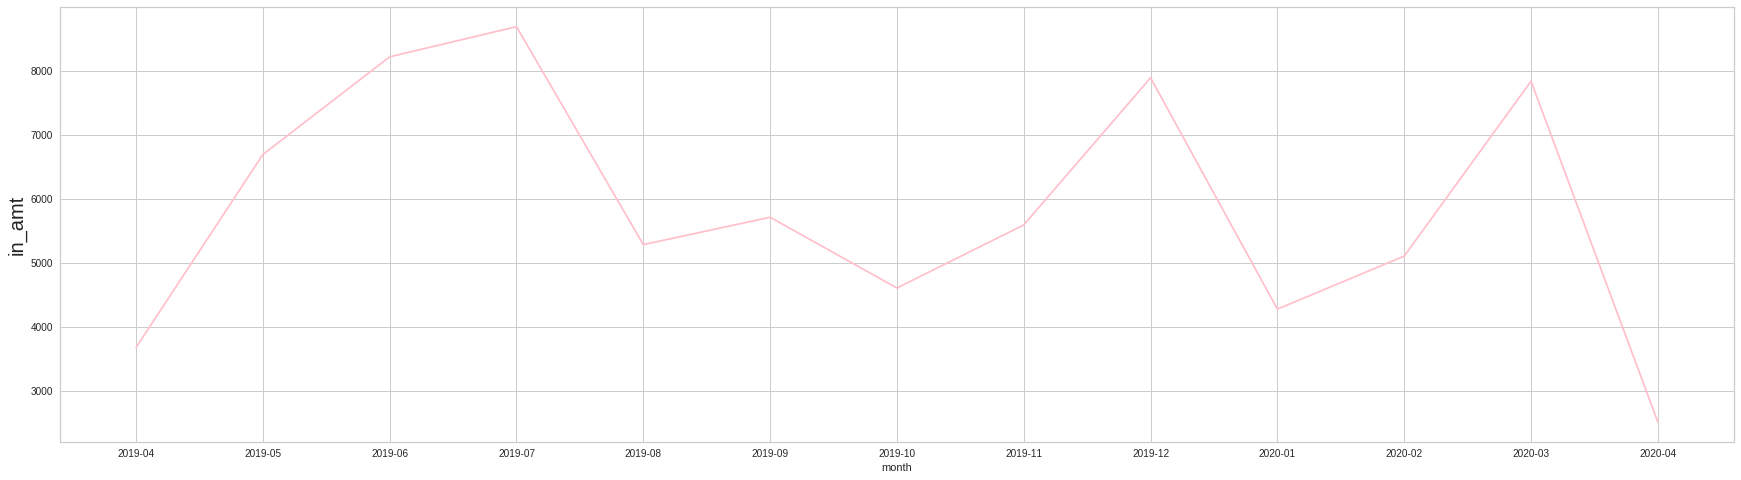

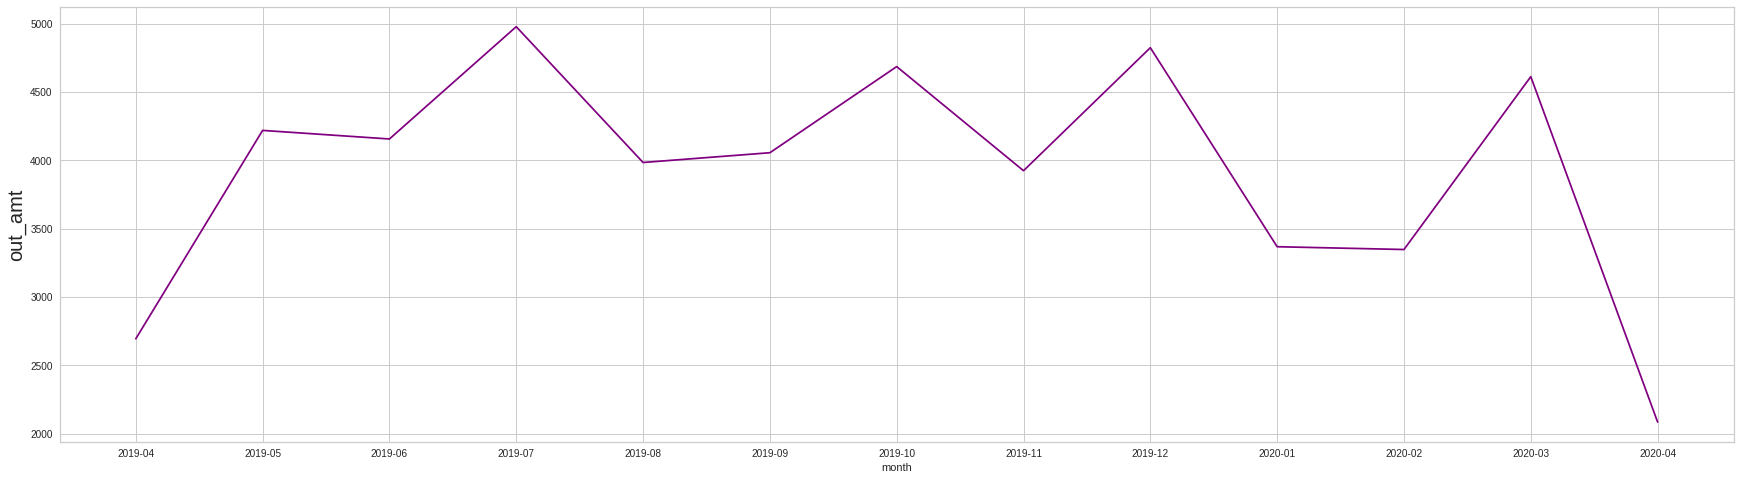

In [ ]:
#transaction data
plt.figure(figsize=(30,8))
sns.lineplot(data=df_transaction.groupby("month").mean(), x="month", y="in_cnt", color="hotpink")
plt.ylabel("in_cnt", fontsize=20)
plt.figure(figsize=(30,8))
sns.lineplot(data=df_transaction.groupby("month").mean(), x="month", y="out_cnt", color="r")
plt.ylabel("out_cnt", fontsize=20)
plt.figure(figsize=(30,8))
sns.lineplot(data=df_transaction.groupby("month").mean(), x="month", y="in_amt", color="pink")
plt.ylabel("in_amt", fontsize=20)
plt.figure(figsize=(30,8))
sns.lineplot(data=df_transaction.groupby("month").mean(), x="month", y="out_amt", color="purple")
plt.ylabel("out_amt", fontsize=20)

Text(0, 0.5, 'Type Count')

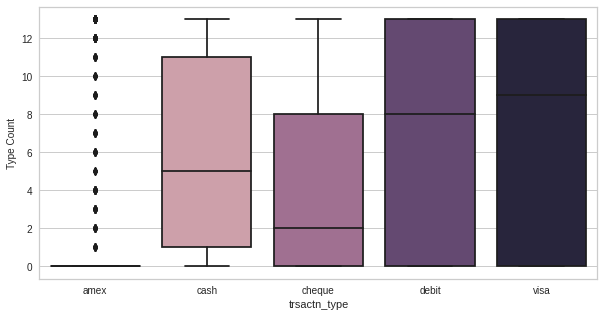

In [ ]:
tran_train_count_trsactn_type=df_transaction.groupby(['customer_id_mskd','trsactn_type']).size().reset_index().rename(columns = {0:'counting'}).groupby(['customer_id_mskd','trsactn_type'])['counting'].aggregate('first').unstack().fillna(0)
plt.figure(figsize=(10,5))
sns.boxplot(data=tran_train_count_trsactn_type,palette="ch:s=-.2,r=.5")
plt.ylabel("Type Count", fontsize=10)

## Easy Model

In [ ]:
### Neural Nets ###

In [ ]:
new_data = df.drop(columns=['customer_id_mskd'])

In [ ]:
# normalizing conitnuous variables (min-max method)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(new_data), columns=new_data.columns)

In [ ]:
df_X=scaled_data.drop(columns=['rating','in_amt_sum', 'in_cnt_sum', 'out_amt_sum', 'out_cnt_sum', 'in_amt_avg',
       'in_cnt_avg', 'out_amt_avg', 'out_cnt_avg', 'in_amt_std', 'in_cnt_std',
       'out_amt_std', 'out_cnt_std', 'in_amt_min', 'in_cnt_min', 'out_amt_min',
       'out_cnt_min', 'in_amt_max', 'in_cnt_max', 'out_amt_max', 'out_cnt_max',
       'in_cnt_null', 'out_cnt_null', 'trsactn_type_count', 'amex', 'cash',
       'cheque', 'debit', 'visa'])

df_Y=df[['rating']]

df_Y = pd.get_dummies(df_Y, 
                        prefix=['rt'], 
                        columns=['rating',])

X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.3, random_state=1)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3128 entries, 2606 to 235
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PCD_CDA            3128 non-null   float64
 1   PCD_CMS            3128 non-null   float64
 2   PCD_CRC            3128 non-null   float64
 3   PCD_LLC            3128 non-null   float64
 4   PCD_MOR            3128 non-null   float64
 5   PCD_MUF            3128 non-null   float64
 6   PCD_SAV            3128 non-null   float64
 7   PCD_SDB            3128 non-null   float64
 8   PCD_TED            3128 non-null   float64
 9   j_CA03             3128 non-null   float64
 10  j_Others           3128 non-null   float64
 11  c_0                3128 non-null   float64
 12  o_Employed/Others  3128 non-null   float64
 13  o_Retired          3128 non-null   float64
 14  o_Self-employed    3128 non-null   float64
 15  o_Unemployed       3128 non-null   float64
 16  csa_Active         312

In [ ]:
#Hyper Paramater tuning for Neural Nets
from keras.regularizers import l1
def search_model(hp):
    model = Sequential()
    model.add(
        Dense(
            hp.Int("neurons1",
                   min_value=16,
                   max_value=512,
                   step=16
                  ),kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01),
            input_dim=28, 
            kernel_initializer = 'uniform',
            activation=hp.Choice('dense_activation',
                                 values=['relu', 'sigmoid'],
                                 default='relu')
        )
    )
    
    for i in range(hp.Int("n_layers",1,3)):
        model.add(
            Dense(
                hp.Int(f"hidden_{i}_neurons",
                       min_value=16,
                       max_value=int(int(512)/int(np.power(2,i))),
                       step=16
                      ),
                kernel_initializer = 'uniform',
                activation=hp.Choice(f"hidden_{i}_dense_activation",
                                     values=['relu', 'sigmoid'],
                                     default='relu')
            )
        )
        
    model.add(Dense(3,kernel_initializer = 'uniform', activation = 'softmax'))
        
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.RMSprop(hp.Float(
            'learning_rate',
            min_value=1e-4,
            max_value=1e-2,
            sampling='LOG',
            default=1e-3
            )
        ),
        metrics=['accuracy'])
    
    return model

In [ ]:
#Random Search using Keras Tuner
import keras
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Optimizer
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from eli5.sklearn import PermutationImportance

inputs = X_train
targets = y_train
batch_size = 50
no_classes = 100
no_epochs = 100
verbosity = 1


tuner = RandomSearch(
    search_model,
    objective = "val_accuracy",
    max_trials = 30,
    executions_per_trial = 1,overwrite=True
    )

tuner.search(x=inputs,
            y=targets,
            epochs = no_epochs,
            batch_size = batch_size,
            validation_data=(X_test,y_test))


Exception ignored in: <function EagerResourceDeleter.__del__ at 0x0000025FA6FC2168>
Traceback (most recent call last):
  File "C:\Users\buttb\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 289, in __del__
    self._handle, ignore_lookup_error=True)
  File "C:\Users\buttb\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\gen_resource_variable_ops.py", line 244, in destroy_resource_op
    ignore_lookup_error)
KeyboardInterrupt: 



Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
neurons1          |112               |?                 
dense_activation  |relu              |?                 
n_layers          |3                 |?                 
hidden_0_neurons  |496               |?                 
hidden_0_dense_...|sigmoid           |?                 
learning_rate     |0.0002766         |?                 



KeyboardInterrupt: 

In [ ]:
#Best Model
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(1)[0]
best_hps.get('learning_rate')

0.004590811887281893

In [ ]:
# test accuracy 
score = best_model.evaluate(X_test,y_test, verbose=2)

42/42 - 0s - loss: 1.0900 - accuracy: 0.4758


In [ ]:
# topology
keras2ascii(best_model)
#ann_viz(model2, view=True, filename="network.gv", title="MyNeural Network")

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####          28
               Dense   XXXXX -------------------      7424     5.4%
                relu   #####         256
               Dense   XXXXX -------------------     94576    68.7%
                relu   #####         368
               Dense   XXXXX -------------------     35424    25.7%
                relu   #####          96
               Dense   XXXXX -------------------       291     0.2%
             softmax   #####           3


In [ ]:
### Other Models ###

In [ ]:
df_X=scaled_data.drop(columns=['rating','in_amt_sum', 'in_cnt_sum', 'out_amt_sum', 'out_cnt_sum', 'in_amt_avg',
       'in_cnt_avg', 'out_amt_avg', 'out_cnt_avg', 'in_amt_std', 'in_cnt_std',
       'out_amt_std', 'out_cnt_std', 'in_amt_min', 'in_cnt_min', 'out_amt_min',
       'out_cnt_min', 'in_amt_max', 'in_cnt_max', 'out_amt_max', 'out_cnt_max',
       'in_cnt_null', 'out_cnt_null', 'trsactn_type_count', 'amex', 'cash',
       'cheque', 'debit', 'visa'])

df_Y=df[['rating']]


X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.3, random_state=1)

In [ ]:
# Construct some pipelines
pipe_lr = Pipeline([('scl', MinMaxScaler()), 
                    ('clf', LogisticRegression(max_iter=1000000))])

pipe_knn = Pipeline([('scl', MinMaxScaler()),
			('clf', KNeighborsClassifier())])

pipe_dt = Pipeline([('scl', MinMaxScaler()),
			('clf', DecisionTreeClassifier(random_state=0))])

pipe_svr = Pipeline([('scl', MinMaxScaler()), 
                    ('clf', SVC())])

pipe_gbr = Pipeline([('scl', MinMaxScaler()), 
                    ('clf', GradientBoostingClassifier(random_state=0))])

pipe_rf = Pipeline([('scl', MinMaxScaler()), 
                    ('clf', RandomForestClassifier(random_state=0))])

#Random Forest Instead
#Neural Nets
#tree depth and minimum leaves per node 

In [ ]:
#Parameters for GridSearchCV
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]
param_gbr_range= [100,200,300]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
		'clf__C': param_range_fl,
		'clf__solver': ['liblinear']}
                 ] 

grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 20, 30],
    'clf__min_samples_split': [20, 40, 60],
    'clf__min_impurity_decrease': [0.001, 0.005, 0.01]
}]

grid_params_knn = [{'clf__n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}]

grid_params_svr = [{'clf__kernel': ['linear', 'rbf'], 
		'clf__C': param_range}]


grid_params_gbr =[{'clf__n_estimators': param_gbr_range,
          'clf__learning_rate': param_range_fl,
          'clf__loss': ['deviance']}]

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 20, 30],
    'clf__min_samples_split': [20, 40, 60],
    'clf__min_impurity_decrease': [0.001, 0.005, 0.01]
}]

In [ ]:

gs_lr = GridSearchCV(estimator=pipe_lr,
			param_grid=grid_params_lr,
			scoring='accuracy',
                     cv=10
			)

gs_svr = GridSearchCV(estimator=pipe_svr,
			param_grid=grid_params_svr,
			scoring='accuracy',
                      cv=10
			)

gs_knn = GridSearchCV(estimator=pipe_knn,
			param_grid=grid_params_knn,
			scoring='accuracy',
                     cv=10)

gs_dt = GridSearchCV(estimator=pipe_dt,
			param_grid=grid_params_dt,
			scoring='accuracy',
                    cv=10)

gs_gbr = GridSearchCV(estimator=pipe_gbr,
			param_grid=grid_params_gbr,
			scoring='accuracy',
                    cv=10)


gs_rf = GridSearchCV(estimator=pipe_rf,
			param_grid=grid_params_rf,
			scoring='accuracy',
                    cv=10)


In [ ]:
grids = [gs_lr, gs_dt,gs_knn, gs_svr,gs_gbr,gs_rf]
grid_dict = { 0: 'Logistic Regression', 1: 'Decision Tree', 2: 'KNN',3: 'SVC',4:'Gradient Boosting Classifier', 
             5:"Random Forest"}

In [ ]:
xtrain_dict=[X_train]
ytrain_dict=[y_train]

xtest_dict=[X_test]
ytest_dict=[y_test]

In [ ]:
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
acc_arr2=[]
for i in range(0,len(xtrain_dict)):
    n=int(i)
    if i==0:
        print("Global Model:")
    else:
        print("Cluster: %i" % (n))
    for idx, gs in enumerate(grids):
        print('\nEstimator: %s' % grid_dict[idx])	
        # Fit grid search	
        gs.fit(xtrain_dict[i], ytrain_dict[i].values.ravel())
        # Best params
        print('Best params: %s' % gs.best_params_)
        # Best training data accuracy
        print('Best training accuracy: %.3f' % gs.best_score_)
        # Predict on test data with best params
        y_pred = gs.predict(xtest_dict[i])
        # Test data accuracy of model with best params
        print('Test set accuracy score for best params: %.3f ' % accuracy_score(ytest_dict[i], y_pred))
        print(classification_report(ytest_dict[i], y_pred))
        # Track best (highest test accuracy) model
        if accuracy_score(ytest_dict[i], y_pred) > best_acc:
            best_acc = accuracy_score(ytest_dict[i], y_pred)
            best_gs = gs
            best_clf = idx
            acc_arr2.append(best_acc)
    print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])
    print('\n')
    best_acc=0



Performing model optimizations...
Global Model:

Estimator: Logistic Regression
Best params: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.429
Test set accuracy score for best params: 0.451 
              precision    recall  f1-score   support

         1.0       0.38      0.34      0.36       371
         2.0       0.48      0.68      0.56       548
         3.0       0.46      0.25      0.32       422

    accuracy                           0.45      1341
   macro avg       0.44      0.42      0.41      1341
weighted avg       0.45      0.45      0.43      1341


Estimator: Decision Tree
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_impurity_decrease': 0.005, 'clf__min_samples_split': 20}
Best training accuracy: 0.431
Test set accuracy score for best params: 0.444 
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       371
         2.0       0.49      0.71    

C:\Users\buttb\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best params: {'clf__n_neighbors': 18}
Best training accuracy: 0.413
Test set accuracy score for best params: 0.429 
              precision    recall  f1-score   support

         1.0       0.36      0.52      0.43       371
         2.0       0.50      0.44      0.47       548
         3.0       0.43      0.33      0.38       422

    accuracy                           0.43      1341
   macro avg       0.43      0.43      0.42      1341
weighted avg       0.44      0.43      0.43      1341


Estimator: SVC
Best params: {'clf__C': 10, 'clf__kernel': 'rbf'}
Best training accuracy: 0.434
Test set accuracy score for best params: 0.450 
              precision    recall  f1-score   support

         1.0       0.35      0.23      0.28       371
         2.0       0.52      0.60      0.56       548
         3.0       0.41      0.45      0.42       422

    accuracy                           0.45      1341
   macro avg       0.43      0.43      0.42      1341
weighted avg       0.44      0.45

In [ ]:
#from sklearn.metrics import classification_report

In [ ]:
model = GradientBoostingClassifier(learning_rate=0.1, loss="deviance", n_estimators=100)
model.fit(X_train, y_train)

C:\Users\buttb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingClassifier()

In [ ]:
#https://stackoverflow.com/questions/39685740/calculate-sklearn-roc-auc-score-for-multi-class
from scipy import interp

from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

In [ ]:
#auc score
report_with_auc = class_report(
    y_true=y_test['rating'], 
    y_pred=model.predict(X_test), 
    y_score=model.predict_proba(X_test))

print(report_with_auc)

             precision    recall  f1-score  support    pred       AUC
1.0           0.371831  0.355795  0.363636    371.0   355.0  0.609941
2.0           0.549669  0.605839  0.576389    548.0   604.0  0.674856
3.0           0.429319  0.388626  0.407960    422.0   382.0  0.639221
avg / total   0.462596  0.468307  0.464526   1341.0  1341.0  0.651864


## Feature Selection

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4469 entries, 0 to 4468
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id_mskd    4469 non-null   object 
 1   PCD_CDA             4469 non-null   float64
 2   PCD_CMS             4469 non-null   float64
 3   PCD_CRC             4469 non-null   float64
 4   PCD_LLC             4469 non-null   float64
 5   PCD_MOR             4469 non-null   float64
 6   PCD_MUF             4469 non-null   float64
 7   PCD_SAV             4469 non-null   float64
 8   PCD_SDB             4469 non-null   float64
 9   PCD_TED             4469 non-null   float64
 10  rating              4469 non-null   float64
 11  in_amt_sum          4469 non-null   float64
 12  in_cnt_sum          4469 non-null   float64
 13  out_amt_sum         4469 non-null   float64
 14  out_cnt_sum         4469 non-null   float64
 15  in_amt_avg          4469 non-null   float64
 16  in_cnt

In [ ]:
### Other Models ###
df_X=df.drop(columns=['rating','customer_id_mskd'])

df_Y=df_cust[['rating']]


X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.3, random_state=1)

In [ ]:
# Decision Tree Feature Importance
model2 = DecisionTreeClassifier(min_samples_leaf=50)
# fit the model
model2.fit(X_train, y_train)
y_predicted = model2.predict(X_test)

Feature: 0, Score: 0.14708
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.01106
Feature: 3, Score: 0.00856
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.02721
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.01048
Feature: 14, Score: 0.00474
Feature: 15, Score: 0.01623
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.07472
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.03019
Feature: 26, Score: 0.10057
Feature: 27, Score: 0.09917
Feature: 28, Score: 0.04836
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.01066
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.01432
Feature: 34, Score: 0.04751
Feature: 35, Score: 0.00000
Fe

<BarContainer object of 56 artists>

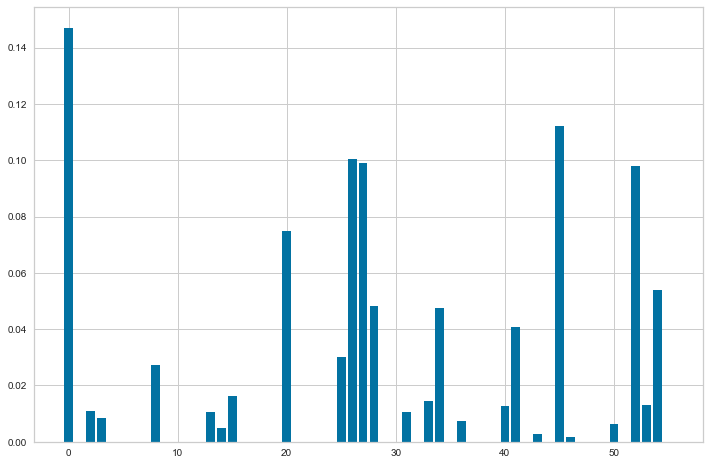

In [ ]:
# get importance
importance = model2.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(12,8))
plt.bar([x for x in range(len(importance))], importance)

In [ ]:
graph=[]
graph2=[]
for i in range (56):
    graph.append(X_train.columns[i])
    graph2.append(importance[i])
    print(X_train.columns[i]," ",i, ": ", importance[i])


PCD_CDA   0 :  0.14707719486660878
PCD_CMS   1 :  0.0
PCD_CRC   2 :  0.011062085706922893
PCD_LLC   3 :  0.008564526951106955
PCD_MOR   4 :  0.0
PCD_MUF   5 :  0.0
PCD_SAV   6 :  0.0
PCD_SDB   7 :  0.0
PCD_TED   8 :  0.0272126448095121
in_amt_sum   9 :  0.0
in_cnt_sum   10 :  0.0
out_amt_sum   11 :  0.0
out_cnt_sum   12 :  0.0
in_amt_avg   13 :  0.010478673247862547
in_cnt_avg   14 :  0.0047425450392515785
out_amt_avg   15 :  0.016230687911598533
out_cnt_avg   16 :  0.0
in_amt_std   17 :  0.0
in_cnt_std   18 :  0.0
out_amt_std   19 :  0.0
out_cnt_std   20 :  0.07472207953302373
in_amt_min   21 :  0.0
in_cnt_min   22 :  0.0
out_amt_min   23 :  0.0
out_cnt_min   24 :  0.0
in_amt_max   25 :  0.030185757627525005
in_cnt_max   26 :  0.10056545902901651
out_amt_max   27 :  0.09916803400991686
out_cnt_max   28 :  0.04835667375129984
in_cnt_null   29 :  0.0
out_cnt_null   30 :  0.0
trsactn_type_count   31 :  0.010656071764712552
amex   32 :  0.0
cash   33 :  0.014318164031911886
cheque   34 : 

In [ ]:
graph_df = dataset = pd.DataFrame({'label': graph, 'FImp': graph2}, columns=['label', 'FImp'])
graph_df=graph_df.sort_values(by='FImp', ascending=False)

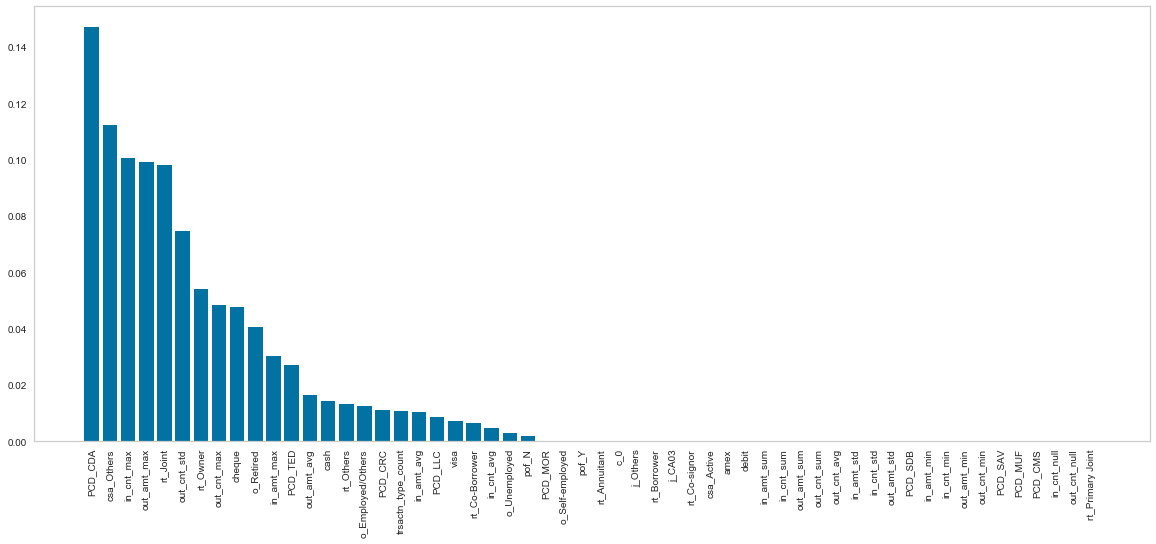

In [ ]:
plt.figure(figsize=(20,8))
plt.bar(graph_df["label"], graph_df["FImp"])
plt.xticks(rotation=90)
plt.grid(b=None)


In [ ]:
import scipy.stats as stat
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier

In [ ]:
#Lasso Regression for Feature Seleciton
log = LogisticRegressionCV(Cs = [15.0, 10.0, 5.0, 2.0, 1.0], cv = 3, penalty='l1', solver='liblinear', max_iter = 2000)

model = log.fit(X_train, y_train)
 

print('Max auc_roc:', log.scores_[1].mean(axis=0).max())

C:\Users\buttb\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Max auc_roc: 0.7113020902487072


In [ ]:
C = pd.DataFrame({'Predictor': np.array(X_train.columns), 'Coefficients': np.array(log.coef_.tolist()[0])})

C = C.loc[C['Coefficients'] != 0]

C.reindex(C['Coefficients'].abs().sort_values(ascending=False).index)

,Predictor,Coefficients
38,j_Others,-1.211907e+00
45,csa_Others,-1.155181e+00
54,rt_Owner,-4.900006e-01
0,PCD_CDA,-3.799143e-01
43,o_Unemployed,-3.701852e-01
51,rt_Co-signor,3.541128e-01
39,c_0,-3.215311e-01
31,trsactn_type_count,-3.091671e-01
42,o_Self-employed,-2.925306e-01
48,rt_Annuitant,-1.927481e-01


In [ ]:
new_col=C["Predictor"].values
new_col

## Medium Model

In [ ]:
#Reset
df=dataProcessing(df_cust, df_transaction)

In [ ]:
new_data = df.drop(columns=['customer_id_mskd'])

In [ ]:
# normalizing conitnuous variables (min-max method)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(new_data), columns=new_data.columns)

In [ ]:
### For Neural Nets ###
df_X=df.drop(columns=['rating','customer_id_mskd'])

df_Y=df_cust[['rating']]


X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.3, random_state=1)

In [ ]:
#### Neural Nets ####

In [ ]:
def search_model(hp):
    model = Sequential()
    model.add(
        Dense(
            hp.Int("neurons1",
                   min_value=16,
                   max_value=512,
                   step=16
                  ),
            input_dim=56, 
            kernel_initializer = 'uniform',
            activation=hp.Choice('dense_activation',
                                 values=['relu', 'sigmoid'],
                                 default='relu')
        )
    )
    
    for i in range(hp.Int("n_layers",1,3)):
        model.add(
            Dense(
                hp.Int(f"hidden_{i}_neurons",
                       min_value=16,
                       max_value=int(int(512)/int(np.power(2,i))),
                       step=16
                      ),
                kernel_initializer = 'uniform',
                activation=hp.Choice(f"hidden_{i}_dense_activation",
                                     values=['relu', 'sigmoid'],
                                     default='relu')
            )
        )
        
    model.add(Dense(3,kernel_initializer = 'uniform', activation = 'softmax'))
        
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.RMSprop(hp.Float(
            'learning_rate',
            min_value=1e-4,
            max_value=1e-2,
            sampling='LOG',
            default=1e-3
            )
        ),
        metrics=['accuracy'])
    
    return model

In [ ]:
inputs = X_train
targets = y_train
batch_size = 50
no_classes = 100
no_epochs = 100
verbosity = 1


tuner = RandomSearch(
    search_model,
    objective = "val_accuracy",
    max_trials = 30,
    executions_per_trial = 1,
    )

tuner.search(x=inputs,
            y=targets,
            epochs = no_epochs,
            batch_size = batch_size,
            validation_data=(X_test,y_test),
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])


Trial 30 Complete [00h 01m 04s]
val_accuracy: 0.4556301236152649

Best val_accuracy So Far: 0.4869500398635864
Total elapsed time: 00h 25m 35s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.get('learning_rate')
best_model = tuner.get_best_models(1)[0]

0.0015041350620866739

In [ ]:
keras2ascii(best_model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####          56
               Dense   XXXXX -------------------     11856    16.3%
             sigmoid   #####         208
               Dense   XXXXX -------------------     60192    82.6%
             sigmoid   #####         288
               Dense   XXXXX -------------------       867     1.2%
             softmax   #####           3


In [ ]:
#Final Model After Paramter Tuning

In [ ]:
y_pred = best_model.predict(X_test)

In [ ]:
# topology
keras2ascii(best_model)
#ann_viz(model, view=True, filename="network.gv", title="MyNeural Network")

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####          56
               Dense   XXXXX -------------------     11856    16.3%
             sigmoid   #####         208
               Dense   XXXXX -------------------     60192    82.6%
             sigmoid   #####         288
               Dense   XXXXX -------------------       867     1.2%
             softmax   #####           3


In [ ]:
### Pipeline ###

In [ ]:
### Other Models ###
df_X=scaled_data[['PCD_CDA', 'PCD_CRC', 'PCD_LLC', 'PCD_MOR', 'PCD_SAV', 'PCD_TED',
       'in_amt_sum', 'in_cnt_sum', 'out_amt_sum', 'out_cnt_sum',
       'in_amt_avg', 'in_cnt_avg', 'out_amt_avg', 'out_cnt_avg',
       'in_amt_std', 'in_cnt_std', 'out_amt_std', 'out_cnt_std',
       'in_amt_min', 'in_cnt_min', 'out_amt_min', 'out_cnt_min',
       'in_amt_max', 'out_amt_max', 'out_cnt_max', 'in_cnt_null',
       'out_cnt_null', 'trsactn_type_count', 'amex', 'cash', 'cheque',
       'debit', 'visa', 'j_Others', 'c_0', 'o_Retired', 'o_Self-employed',
       'o_Unemployed', 'csa_Others', 'pof_N', 'rt_Annuitant',
       'rt_Borrower', 'rt_Co-Borrower', 'rt_Co-signor', 'rt_Joint',
       'rt_Owner', 'rt_Primary Joint']]

df_Y=df_cust[['rating']]

df_Y = pd.get_dummies(df_Y, 
                        prefix=['rt'], 
                        columns=['rating',])
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.3, random_state=1)

In [ ]:
# Construct some pipelines
pipe_lr = Pipeline([('scl', MinMaxScaler()), 
                    ('clf', LogisticRegression(max_iter=1000000))])

pipe_knn = Pipeline([('scl', MinMaxScaler()),
			('clf', KNeighborsClassifier())])

pipe_dt = Pipeline([('scl', MinMaxScaler()),
			('clf', DecisionTreeClassifier(random_state=0))])

pipe_svr = Pipeline([('scl', MinMaxScaler()), 
                    ('clf', SVC())])

pipe_gbr = Pipeline([('scl', MinMaxScaler()), 
                    ('clf', GradientBoostingClassifier(random_state=0))])

pipe_rf = Pipeline([('scl', MinMaxScaler()), 
                    ('clf', RandomForestClassifier(random_state=0))])

#Random Forest Instead
#Neural Nets
#

In [ ]:
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]
param_gbr_range= [100,200,300]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
		'clf__C': param_range_fl,
		'clf__solver': ['liblinear']}
                 ] 

grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 20, 30],
    'clf__min_samples_split': [20, 40, 60],
    'clf__min_impurity_decrease': [0.001, 0.005, 0.01]
}]

grid_params_knn = [{'clf__n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}]

grid_params_svr = [{'clf__kernel': ['linear', 'rbf'], 
		'clf__C': param_range}]


grid_params_gbr =[{'clf__n_estimators': param_gbr_range,
          'clf__learning_rate': param_range_fl,
          'clf__loss': ['deviance']}]

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 20, 30],
    'clf__min_samples_split': [20, 40, 60],
    'clf__min_impurity_decrease': [0.001, 0.005, 0.01]
}]

In [ ]:

gs_lr = GridSearchCV(estimator=pipe_lr,
			param_grid=grid_params_lr,
			scoring='accuracy',
                     cv=10
			)

gs_svr = GridSearchCV(estimator=pipe_svr,
			param_grid=grid_params_svr,
			scoring='accuracy',
                      cv=10
			)

gs_knn = GridSearchCV(estimator=pipe_knn,
			param_grid=grid_params_knn,
			scoring='accuracy',
                     cv=10)

gs_dt = GridSearchCV(estimator=pipe_dt,
			param_grid=grid_params_dt,
			scoring='accuracy',
                    cv=10)

gs_gbr = GridSearchCV(estimator=pipe_gbr,
			param_grid=grid_params_gbr,
			scoring='accuracy',
                    cv=10)


gs_rf = GridSearchCV(estimator=pipe_rf,
			param_grid=grid_params_rf,
			scoring='accuracy',
                    cv=10)


In [ ]:
grids = [gs_lr, gs_dt,gs_knn, gs_svr,gs_gbr,gs_rf]
grid_dict = { 0: 'Logistic Regression', 1: 'Decision Tree', 2: 'KNN',3: 'SVC',4:'Gradient Boosting Classifier', 
             5:"Random Forest"}

In [ ]:
xtrain_dict=[X_train[['PCD_CDA', 'PCD_CRC', 'PCD_LLC', 'PCD_MOR', 'PCD_SAV', 'PCD_TED',
       'in_amt_sum', 'in_cnt_sum', 'out_amt_sum', 'out_cnt_sum',
       'in_amt_avg', 'in_cnt_avg', 'out_amt_avg', 'out_cnt_avg',
       'in_amt_std', 'in_cnt_std', 'out_amt_std', 'out_cnt_std',
       'in_amt_min', 'in_cnt_min', 'out_amt_min', 'out_cnt_min',
       'in_amt_max', 'out_amt_max', 'out_cnt_max', 'in_cnt_null',
       'out_cnt_null', 'trsactn_type_count', 'amex', 'cash', 'cheque',
       'debit', 'visa', 'j_Others', 'c_0', 'o_Retired', 'o_Self-employed',
       'o_Unemployed', 'csa_Others', 'pof_N', 'rt_Annuitant',
       'rt_Borrower', 'rt_Co-Borrower', 'rt_Co-signor', 'rt_Joint',
       'rt_Owner', 'rt_Primary Joint']]]
ytrain_dict=[y_train]

xtest_dict=[X_test[['PCD_CDA', 'PCD_CRC', 'PCD_LLC', 'PCD_MOR', 'PCD_SAV', 'PCD_TED',
       'in_amt_sum', 'in_cnt_sum', 'out_amt_sum', 'out_cnt_sum',
       'in_amt_avg', 'in_cnt_avg', 'out_amt_avg', 'out_cnt_avg',
       'in_amt_std', 'in_cnt_std', 'out_amt_std', 'out_cnt_std',
       'in_amt_min', 'in_cnt_min', 'out_amt_min', 'out_cnt_min',
       'in_amt_max', 'out_amt_max', 'out_cnt_max', 'in_cnt_null',
       'out_cnt_null', 'trsactn_type_count', 'amex', 'cash', 'cheque',
       'debit', 'visa', 'j_Others', 'c_0', 'o_Retired', 'o_Self-employed',
       'o_Unemployed', 'csa_Others', 'pof_N', 'rt_Annuitant',
       'rt_Borrower', 'rt_Co-Borrower', 'rt_Co-signor', 'rt_Joint',
       'rt_Owner', 'rt_Primary Joint']]]
ytest_dict=[y_test]

In [ ]:
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
acc_arr2=[]
for i in range(0,len(xtrain_dict)):
    n=int(i)
    if i==0:
        print("Global Model:")
    else:
        print("Cluster: %i" % (n))
    for idx, gs in enumerate(grids):
        print('\nEstimator: %s' % grid_dict[idx])	
        # Fit grid search	
        gs.fit(xtrain_dict[i], ytrain_dict[i].values.ravel())
        # Best params
        print('Best params: %s' % gs.best_params_)
        # Best training data accuracy
        print('Best training accuracy: %.3f' % gs.best_score_)
        # Predict on test data with best params
        y_pred = gs.predict(xtest_dict[i])
        # Test data accuracy of model with best params
        print('Test set accuracy score for best params: %.3f ' % accuracy_score(ytest_dict[i], y_pred))
        print(classification_report(ytest_dict[i], y_pred))
        # Track best (highest test accuracy) model
        if accuracy_score(ytest_dict[i], y_pred) > best_acc:
            best_acc = accuracy_score(ytest_dict[i], y_pred)
            best_gs = gs
            best_clf = idx
            acc_arr2.append(best_acc)
    print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])
    print('\n')
    best_acc=0



Performing model optimizations...
Global Model:

Estimator: Logistic Regression
Best params: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.449
Test set accuracy score for best params: 0.452 
              precision    recall  f1-score   support

         1.0       0.39      0.26      0.31       545
         2.0       0.48      0.65      0.55       684
         3.0       0.44      0.39      0.41       559

    accuracy                           0.45      1788
   macro avg       0.44      0.44      0.43      1788
weighted avg       0.44      0.45      0.44      1788


Estimator: Decision Tree
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_impurity_decrease': 0.001, 'clf__min_samples_split': 60}
Best training accuracy: 0.456
Test set accuracy score for best params: 0.438 
              precision    recall  f1-score   support

         1.0       0.39      0.34      0.36       545
         2.0       0.51      0.51    

In [ ]:
#BEst Model should be Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=0,learning_rate=0.1, loss='deviance', n_estimators=100)
model.fit(X_train, y_train)

/usr/local/lib64/python3.6/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
#auc score
report_with_auc = class_report(
    y_true=y_test['rating'], 
    y_pred=model.predict(X_test), 
    y_score=model.predict_proba(X_test))

print(report_with_auc)

             precision    recall  f1-score  support    pred       AUC
1.0           0.392936  0.326606  0.356713    545.0   453.0  0.610482
2.0           0.504294  0.600877  0.548366    684.0   815.0  0.671934
3.0           0.432692  0.402504  0.417053    559.0   520.0  0.640295
avg / total   0.447966  0.455257  0.448895   1788.0  1788.0  0.646521


## Hard Model

## K-Means Clustering

In [ ]:
msk = np.random.rand(len(df)) < 0.7

train = df[msk]

test = df[~msk]

In [ ]:
train.info()

In [ ]:
X= df.drop(columns=['customer_id_mskd','rating'])
y=df["rating"]


In [ ]:
# Correlation matrix
corr = df.corr()

plt.figure(figsize=(50,50))
sns.heatmap(corr, 
            mask=np.triu(np.ones_like(corr, dtype=bool)), 
            cmap=sns.diverging_palette(230, 10, as_cmap=True),
            square=True,
            cbar_kws={"shrink": 0.75},
            annot=True,
            annot_kws={'size':12})

In [ ]:
# normalizing conitnuous variables (min-max method)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)

In [ ]:
scaled_df

array([[0.1       , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.22222222, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.22222222, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.1       , 0.        , 0.44444444, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1       , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# choose a suitable k  - instantiate the clustering model and visualizer
model = KMeans(random_state=123)
visualizer = KElbowVisualizer(model, k=(2,25), timings=False)
visualizer.fit(scaled_df) 
visualizer.show()

In [ ]:
# choose a suitable k - elbow method
kmeans_kwargs = {
    "random_state": 1111,
}

#sse = []
#for k in range(1, 20):
 #   model = KMeans(n_clusters = k, **kmeans_kwargs)
  #3  model.fit(scaled_df)
    #sse.append(model.inertia_)

In [ ]:
# choose a suitable k - silhouette coefficient
silhouette_coefficients = []

for k in range(2, 20):
    model = KMeans(n_clusters = k, **kmeans_kwargs)
    model.fit(scaled_df) 
    score = silhouette_score(scaled_df, model.labels_)
    silhouette_coefficients.append(score)

In [ ]:
plt.figure(figsize = (10,15))
plt.style.use("default")
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")

In [ ]:
# final model
kmmodel = KMeans(n_clusters = 10, **kmeans_kwargs)
kmmodel.fit(scaled_df)

KMeans(n_clusters=10, random_state=1111)

In [ ]:
# add labels back to original data
labels = pd.DataFrame(kmmodel.labels_)
df['labels'] = labels

In [ ]:
train.head()

In [ ]:
df["rating"].value_counts()

2.0    1759
3.0    1399
1.0    1311
Name: rating, dtype: int64

In [ ]:
df.groupby('labels').mean()

,PCD_CDA,PCD_CMS,PCD_CRC,PCD_LLC,PCD_MOR,PCD_MUF,PCD_SAV,PCD_SDB,PCD_TED,rating,in_amt_sum,in_cnt_sum,out_amt_sum,out_cnt_sum,in_amt_avg,in_cnt_avg,out_amt_avg,out_cnt_avg,in_amt_std,in_cnt_std,out_amt_std,out_cnt_std,in_amt_min,in_cnt_min,out_amt_min,out_cnt_min,in_amt_max,in_cnt_max,out_amt_max,out_cnt_max,in_cnt_null,out_cnt_null,trsactn_type_count,amex,cash,cheque,debit,visa,j_CA03,j_Others,c_0,o_Employed/Others,o_Retired,o_Self-employed,o_Unemployed,csa_Active,csa_Others,pof_N,pof_Y,rt_Annuitant,rt_Borrower,rt_Co-Borrower,rt_Co-signor,rt_Joint,rt_Others,rt_Owner,rt_Primary Joint
labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.391304,0.0,0.245747,0.279773,0.141777,0.0,0.236295,0.039698,0.119093,2.096408,11473.856441,6.332703,11297.547131,53.466919,1674.693491,0.576105,649.677837,3.184835,1785.692407,0.295075,1059.727120,2.268880,747.423715,0.310019,100.587876,0.640832,6161.369813,1.172023,4588.706662,7.922495,1.988658,0.659735,0.659735,0.149338,0.937618,0.625709,1.164461,1.826087,0.982987,0.017013,1.0,1.000000,0.000000,0.000000,0.000000,0.943289,0.056711,1.000000,0.000000,0.000000,0.000000,0.306238,0.088847,0.332703,0.181474,0.090737,0.000000
1,0.907336,0.0,1.229730,0.393822,0.090734,0.0,0.484556,0.013514,0.102317,2.028958,81856.276872,53.254826,94184.811434,545.200772,3771.311588,2.417620,2495.339906,16.918073,7140.354373,1.552553,4888.620438,16.941724,125.845002,1.003861,77.013952,1.223938,29673.565761,6.247104,26236.770571,57.528958,17.110039,4.621622,3.691120,0.978764,9.372587,6.096525,11.507722,8.534749,0.990347,0.009653,1.0,0.797297,0.098456,0.067568,0.036680,0.990347,0.009653,0.025097,0.974903,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
2,0.166271,0.0,0.182898,0.242280,0.128266,0.0,0.334917,0.028504,0.439430,2.068884,31184.781779,8.945368,29098.822860,58.843230,5701.826186,0.956984,2572.522596,4.779015,4546.513558,0.431519,4064.860946,3.016397,2387.116483,0.546318,249.508545,1.073634,14432.760531,1.781473,11843.123644,10.049881,2.007126,0.862233,1.059382,0.308789,0.876485,0.536817,0.940618,3.237530,0.992874,0.007126,1.0,1.000000,0.000000,0.000000,0.000000,0.976247,0.023753,0.000000,1.000000,0.111639,0.375297,0.000000,0.000000,0.000000,0.000000,0.313539,0.199525
3,1.315385,0.0,0.000000,0.000000,0.000000,0.0,0.411538,0.134615,0.000000,2.011538,125523.068165,49.296154,147702.024262,468.426923,8365.563042,2.333894,4583.484936,13.771049,18511.524780,1.565467,10100.380829,14.423598,187.929214,0.984615,88.425149,1.169231,66414.685080,6.530769,50731.316262,48.623077,17.561538,3.926923,3.511538,0.873077,9.003846,7.315385,10.450000,6.988462,0.980769,0.019231,1.0,0.588462,0.215385,0.150000,0.046154,0.996154,0.003846,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,0.476923,0.0,0.423077,0.169231,0.023077,0.0,0.325641,0.007692,0.425641,1.843590,27571.174513,7.169231,40948.769554,45.866667,10101.330213,0.776847,4449.298826,3.053316,7144.919658,0.321202,7613.394315,2.219181,6193.907875,0.487179,859.893387,0.671795,22415.892105,1.376923,25928.928916,7.456410,3.948718,0.915385,1.241026,0.166667,1.800000,1.579487,1.607692,1.992308,0.989744,0.010256,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.043590,0.061538,0.000000,0.000000,0.000000,0.520513,0.220513,0.153846
5,0.326718,0.0,0.682443,0.403053,0.045802,0.0,0.203053,0.009160,0.044275,1.963359,7418.151855,6.390840,7827.715277,44.416794,1405.466549,0.755733,997.933529,3.733970,1194.686765,0.300855,962.736878,2.423440,518.568584,0.471756,290.418977,0.842748,3260.532899,1.306870,2848.820817,8.273282,1.728244,0.645802,0.891603,0.184733,0.732824,0.322137,0.783206,2.734351,0.993893,0.006107,1.0,1.000000,0.000000,0.000000,0.000000,0.992366,0.007634,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
6,0.022346,0.0,0.309125,0.184358,0.178771,0.0,0.538175,0.005587,0.757914,1.977654,131307.829857,63.324022,125242.813677,617.666667,6637.

In [ ]:
a.to_csv("train_set_big_data.csv",header=True)

In [ ]:
#Test Set 
X_test= test.drop(columns=['customer_id_mskd','rating'])
y_test=test["rating"]


In [ ]:
# normalizing conitnuous variables (min-max method)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_df_test = scaler.fit_transform(X_test)

In [ ]:
labels_test=kmmodel.predict(scaled_df_test)

In [ ]:
test['labels'] = labels_test

In [ ]:
test["labels"].value_counts()

In [ ]:
df.groupby('labels').mean()

In [ ]:
a.to_csv("test_set_big_data.csv",header=True)

In [ ]:
sns.countplot(x=test['labels'])
plt.ylim(0,400)
plt.title("Test Set Labels Distribution")

In [ ]:
sns.countplot(x=train['labels'])
plt.ylim(0,400)
plt.title("Training Set Labels Distribution")


In [ ]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(a)

In [ ]:
sns.countplot(x=df['labels'])
plt.ylim(0,800)

In [ ]:
df['labels'].value_counts()

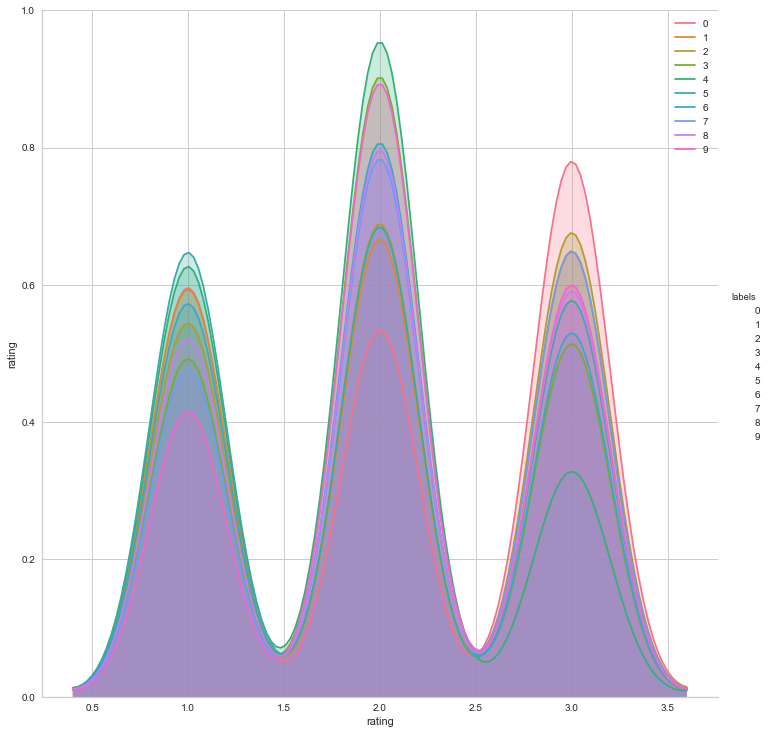

In [ ]:
sns.pairplot(df[["rating", "labels"]], hue="labels", height=10,diag_kws={'bw': 0.2})
plt.legend()

In [ ]:
cluster_9["rating"].value_counts()

In [ ]:
# model
brc = Birch(n_clusters = 10)
brc.fit(scaled_df)

Birch(n_clusters=10)

In [ ]:
# add labels back to original data
labels = pd.DataFrame(brc.labels_)
df['brc_labels'] = labels

In [ ]:
df.groupby('brc_labels').mean()

In [ ]:
df['brc_labels'].value_counts()

In [ ]:
plt.figure(figsize=(20,30))
sns.pairplot(df[["rating", "brc_labels"]], hue="brc_labels", size=10, diag_kws={'bw': 0.2})
plt.legend()

## Segmentation Modeling

In [ ]:
df.head()

,customer_id_mskd,PCD_CDA,PCD_CMS,PCD_CRC,PCD_LLC,PCD_MOR,PCD_MUF,PCD_SAV,PCD_SDB,PCD_TED,rating,in_amt_sum,in_cnt_sum,out_amt_sum,out_cnt_sum,in_amt_avg,in_cnt_avg,out_amt_avg,out_cnt_avg,in_amt_std,in_cnt_std,out_amt_std,out_cnt_std,in_amt_min,in_cnt_min,out_amt_min,out_cnt_min,in_amt_max,in_cnt_max,out_amt_max,out_cnt_max,in_cnt_null,out_cnt_null,trsactn_type_count,amex,cash,cheque,debit,visa,j_CA03,j_Others,c_0,o_Employed/Others,o_Retired,o_Self-employed,o_Unemployed,csa_Active,csa_Others,pof_N,pof_Y,rt_Annuitant,rt_Borrower,rt_Co-Borrower,rt_Co-signor,rt_Joint,rt_Others,rt_Owner,rt_Primary Joint,rating_binary,brc_labels
0,df39588796bc20fb01d282213200c944ad38caa06a91a7...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,47884.28,127.0,57053.62,617.0,2816.722353,7.470588,1462.913333,15.820513,2071.229031,4.302872,1912.801055,22.320479,170.0,1.0,2.11,1.0,6862.54,14.0,6282.50,67.0,23.0,1.0,4.0,0.0,10.0,6.0,11.0,13.0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0
1,d56f5632aa40d2661dcc5419def6ede2ed4cca24bd76cd...,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,197850.44,34.0,140360.36,289.0,12365.652500,2.125000,3598.983590,7.410256,21738.433399,0.957427,10075.856244,6.800611,410.0,1.0,80.00,1.0,67000.00,4.0,53813.81,24.0,23.0,0.0,3.0,0.0,0.0,13.0,13.0,13.0,1,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,3
2,a86efc98b6e70bbb37c12024304f3d7c9eac9e4ecd9559...,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,3.0,61087.87,63.0,136307.92,859.0,2655.994348,2.739130,2672.704314,16.843137,2369.653663,1.912100,2177.988412,18.332891,19.9,1.0,60.00,1.0,8619.19,7.0,13361.32,64.0,28.0,0.0,4.0,0.0,13.0,12.0,13.0,13.0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,3
3,24f154d9bb05a18ba723830b6c41d6eb71a67f14ca7325...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,2978.48,17.0,0.00,0.0,248.206667,1.416667,0.000000,0.000000,570.059784,0.668558,0.000000,0.000000,15.0,1.0,0.00,0.0,2046.33,3.0,0.00,0.0,0.0,12.0,3.0,0.0,4.0,5.0,3.0,0.0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,2
4,bdb58c996ed0b5c9f81461caa8efe914f712e22ffaa6ac...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,1


In [ ]:
df["rating_binary"]= np.where(df["rating"]==3.0,1,0)

In [ ]:
df_X=df.drop(columns=['labels','rating','brc_labels','customer_id_mskd',"rating_binary"])
df_Y=df[['rating']]
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.4, random_state=42)


In [ ]:
# separate clusters
cluster_1 = df.loc[df['labels'] == 0]
cluster_1 = cluster_1.reset_index(drop=True)
cluster_1_X = cluster_1.drop(columns=['labels','rating','brc_labels','customer_id_mskd',"rating_binary"])
cluster_1_Y = cluster_1[['rating']]

X_train1, X_test1, y_train1, y_test1 = train_test_split(cluster_1_X, cluster_1_Y, test_size=0.4, random_state=42)


cluster_2 = df.loc[df['labels'] == 1]
cluster_2 = cluster_2.reset_index(drop=True)
cluster_2_X = cluster_2.drop(columns=['labels','rating','brc_labels','customer_id_mskd',"rating_binary"])
cluster_2_Y = cluster_2[['rating']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(cluster_2_X, cluster_2_Y, test_size=0.4, random_state=42)


cluster_3 = df.loc[df['labels'] == 2]
cluster_3 = cluster_3.reset_index(drop=True)
cluster_3_X = cluster_3.drop(columns=['labels','rating','brc_labels','customer_id_mskd',"rating_binary"])
cluster_3_Y = cluster_3[['rating']]
X_train3, X_test3, y_train3, y_test3 = train_test_split(cluster_3_X, cluster_3_Y, test_size=0.4, random_state=42)


cluster_4 = df.loc[df['labels'] == 3]
cluster_4 = cluster_4.reset_index(drop=True)
cluster_4_X = cluster_4.drop(columns=['labels','rating','brc_labels','customer_id_mskd',"rating_binary"])
cluster_4_Y = cluster_4[['rating']]
X_train4, X_test4, y_train4, y_test4 = train_test_split(cluster_4_X, cluster_4_Y, test_size=0.4, random_state=42)


cluster_5 = df.loc[df['labels'] == 4]
cluster_5 = cluster_5.reset_index(drop=True)
cluster_5_X = cluster_5.drop(columns=['labels','rating','brc_labels','customer_id_mskd',"rating_binary"])
cluster_5_Y = cluster_5[['rating']]
X_train5, X_test5, y_train5, y_test5 = train_test_split(cluster_5_X, cluster_5_Y, test_size=0.4, random_state=42)


cluster_6 = df.loc[df['labels'] == 5]
cluster_6 = cluster_6.reset_index(drop=True)
cluster_6_X = cluster_6.drop(columns=['labels','rating','brc_labels','customer_id_mskd',"rating_binary"])
cluster_6_Y = cluster_6[['rating']]
X_train6, X_test6, y_train6, y_test6 = train_test_split(cluster_6_X, cluster_6_Y, test_size=0.4, random_state=42)


cluster_7 = df.loc[df['labels'] == 6]
cluster_7 = cluster_7.reset_index(drop=True)
cluster_7_X = cluster_7.drop(columns=['labels','rating','brc_labels','customer_id_mskd',"rating_binary"])
cluster_7_Y = cluster_7[['rating']]
X_train7, X_test7, y_train7, y_test7 = train_test_split(cluster_7_X, cluster_7_Y, test_size=0.4, random_state=42)


cluster_8 = df.loc[df['labels'] == 7]
cluster_8 = cluster_8.reset_index(drop=True)
cluster_8_X = cluster_8.drop(columns=['labels','rating','brc_labels','customer_id_mskd',"rating_binary"])
cluster_8_Y = cluster_8[['rating']]
X_train8, X_test8, y_train8, y_test8 = train_test_split(cluster_8_X, cluster_8_Y, test_size=0.4, random_state=42)


cluster_9 = df.loc[df['labels'] == 8]
cluster_9 = cluster_9.reset_index(drop=True)
cluster_9_X = cluster_9.drop(columns=['labels','rating','brc_labels','customer_id_mskd',"rating_binary"])
cluster_9_Y = cluster_9[['rating']]
X_train9, X_test9, y_train9, y_test9 = train_test_split(cluster_9_X, cluster_9_Y, test_size=0.4, random_state=42)


cluster_10 = df.loc[df['labels'] == 9]
cluster_10 = cluster_10.reset_index(drop=True)
cluster_10_X = cluster_10.drop(columns=['labels','rating','brc_labels','customer_id_mskd',"rating_binary"])
cluster_10_Y = cluster_10[['rating']]
X_train10, X_test10, y_train10, y_test10 = train_test_split(cluster_10_X, cluster_10_Y, test_size=0.4, random_state=42)

#cluster_11 = df.loc[df['labels'] == 10]
#cluster_11 = cluster_11.reset_index(drop=True)
#cluster_11_X = cluster_11.drop(columns=['labels','rating','brc_labels','customer_id_mskd',"rating_binary"])
#cluster_11_Y = cluster_11[['rating']]
#X_train11, X_test11, y_train11, y_test11 = train_test_split(cluster_11_X, cluster_11_Y, test_size=0.4, random_state=42)


In [ ]:
def crosstab_analysis(df, predictor1, predictor2):
    
    ax= pd.crosstab(df[predictor1], df[predictor2]).apply(lambda r: r/r.sum()*100, axis=1)
    ax_1 = ax.plot.bar(figsize=(10,10),stacked=True, rot=30)

    plt.legend(loc='lower center', bbox_to_anchor=(0.1, 1.0), title="Subject")
    plt.title(predictor1+' '+predictor2 +' plot')
    if predictor2 == 'rating':
        plt.ylabel('y')
    else:
        plt.ylabel(predictor2)

    for rec in ax_1.patches:
        height = rec.get_height()
        ax_1.text(rec.get_x() + rec.get_width() / 2, rec.get_y() + height / 2,"{:.0f}%".format(height),
                ha='center', va='bottom')

    plt.savefig(predictor1+' '+predictor2 +' plot.png', dpi=300, bbox_inches='tight')
    plt.show()

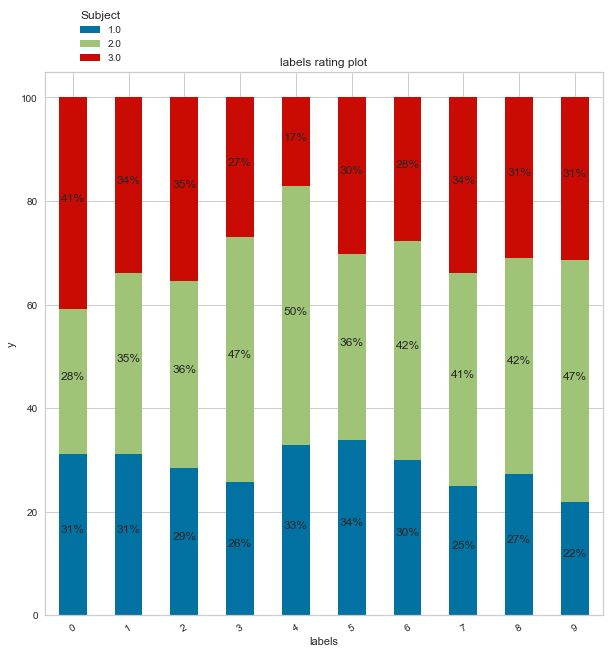

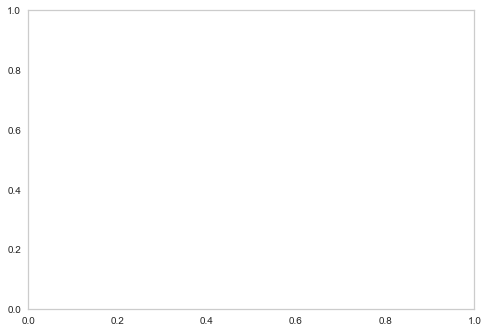

In [ ]:
crosstab_analysis(df, "labels","rating")
plt.grid(b=None)

## Pipeline Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# Construct some pipelines
pipe_lr = Pipeline([('scl', MinMaxScaler()), 
                    ('clf', LogisticRegression(max_iter=1000000))])

pipe_knn = Pipeline([('scl', MinMaxScaler()),
			('clf', KNeighborsClassifier())])

pipe_dt = Pipeline([('scl', MinMaxScaler()),
			('clf', DecisionTreeClassifier(random_state=0))])

pipe_svr = Pipeline([('scl', MinMaxScaler()), 
                    ('clf', SVC())])

pipe_gbr = Pipeline([('scl', MinMaxScaler()), 
                    ('clf', GradientBoostingClassifier(random_state=0))])

pipe_rf = Pipeline([('scl', MinMaxScaler()), 
                    ('clf', RandomForestClassifier(random_state=0))])

#Random Forest Instead
#Neural Nets
#

In [ ]:
#potentially make target variable binary, but not now

In [ ]:
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]
param_gbr_range= [100,200,300]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
		'clf__C': param_range_fl,
		'clf__solver': ['liblinear']}
                 ] 

grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 20, 30],
    'clf__min_samples_split': [20, 40, 60],
    'clf__min_impurity_decrease': [0.001, 0.005, 0.01]
}]

grid_params_knn = [{'clf__n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}]

grid_params_svr = [{'clf__kernel': ['linear', 'rbf'], 
		'clf__C': param_range}]


grid_params_gbr =[{'clf__n_estimators': param_gbr_range,
          'clf__learning_rate': param_range_fl,
          'clf__loss': ['deviance']}]

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 20, 30],
    'clf__min_samples_split': [20, 40, 60],
    'clf__min_impurity_decrease': [0.001, 0.005, 0.01]
}]

In [ ]:

gs_lr = GridSearchCV(estimator=pipe_lr,
			param_grid=grid_params_lr,
			scoring='accuracy',
                     cv=10
			)

gs_svr = GridSearchCV(estimator=pipe_svr,
			param_grid=grid_params_svr,
			scoring='accuracy',
                      cv=10
			)

gs_knn = GridSearchCV(estimator=pipe_knn,
			param_grid=grid_params_knn,
			scoring='accuracy',
                     cv=10)

gs_dt = GridSearchCV(estimator=pipe_dt,
			param_grid=grid_params_dt,
			scoring='accuracy',
                    cv=10)

gs_gbr = GridSearchCV(estimator=pipe_gbr,
			param_grid=grid_params_gbr,
			scoring='accuracy',
                    cv=10)


gs_rf = GridSearchCV(estimator=pipe_rf,
			param_grid=grid_params_rf,
			scoring='accuracy',
                    cv=10)


In [ ]:
grids = [gs_lr, gs_dt,gs_knn, gs_svr,gs_gbr,gs_rf]
grid_dict = { 0: 'Logistic Regression', 1: 'Decision Tree', 2: 'KNN',3: 'SVC',4:'Gradient Boosting Classifier', 5:"Random Forest"}

In [ ]:
xtrain_dict=[X_train, X_train1,X_train2, X_train3, X_train4, X_train5,X_train6,X_train7,X_train8,X_train9,X_train10]
ytrain_dict=[y_train,y_train1,y_train2,y_train3,y_train4,y_train5,y_train6,y_train7,y_train8,y_train9,y_train10]

xtest_dict=[X_test, X_test1,X_test2,X_test3,X_test4,X_test5,X_test6,X_test7,X_test8,X_test9,X_test10]
ytest_dict=[y_test, y_test1,y_test2,y_test3,y_test4,y_test5,y_test6,y_test7,y_test8,y_test9,y_test10]

In [ ]:
target_names=["low","med","high"]

In [ ]:
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
acc_arr=[]
for i in range(0,len(xtrain_dict)):
    n=int(i)
    if i==0:
        print("Global Model:")
    else:
        print("Cluster: %i" % (n))
    for idx, gs in enumerate(grids):
        print('\nEstimator: %s' % grid_dict[idx])	
        # Fit grid search	
        gs.fit(xtrain_dict[i], ytrain_dict[i].values.ravel())
        # Best params
        print('Best params: %s' % gs.best_params_)
        # Best training data accuracy
        print('Best training accuracy: %.3f' % gs.best_score_)
        # Predict on test data with best params
        y_pred = gs.predict(xtest_dict[i])
        # Test data accuracy of model with best params
        print('Test set accuracy score for best params: %.3f ' % accuracy_score(ytest_dict[i], y_pred))
        print(classification_report(ytest_dict[i], y_pred))
        # Track best (highest test accuracy) model
        if accuracy_score(ytest_dict[i], y_pred) > best_acc:
            best_acc = accuracy_score(ytest_dict[i], y_pred)
            best_gs = gs
            best_clf = idx
            acc_arr.append(best_acc)
    print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])
    print('\n')
    best_acc=0



In [ ]:
0.451 

In [ ]:
weights_arr=[]
for i in range(1,len(xtest_dict)):
   weights_arr.append(len(xtest_dict[i])/len(xtest_dict[0]))

In [ ]:
for i in range(0,len(xtest_dict)):
   print(len(xtest_dict[i]))

In [ ]:
sum(np.multiply(weights_arr, [0.448  ,0.447 ,0.408 , 0.529 ,0.494 ,0.504,0.400,0.533 , 0.545 , 0.507 ]))

In [ ]:
((0.4770855704697986/0.45)-1)*100

In [ ]:
((0.4770855704697986/0.33333333333333)-1)*100

## Binary Classifications

In [ ]:
df.head()

In [ ]:
df_X=df.drop(columns=['labels','rating','brc_labels','customer_id_mskd','rating_binary'])
df_Y=df['rating_binary']
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.4, random_state=42)

In [ ]:
# separate clusters
cluster_1 = df.loc[df['labels'] == 0]
cluster_1 = cluster_1.reset_index(drop=True)
cluster_1_X = cluster_1.drop(columns=['labels','rating','brc_labels','customer_id_mskd','rating_binary'])
cluster_1_Y = cluster_1[['rating_binary']]

X_train1, X_test1, y_train1, y_test1 = train_test_split(cluster_1_X, cluster_1_Y, test_size=0.4, random_state=42)


cluster_2 = df.loc[df['labels'] == 1]
cluster_2 = cluster_2.reset_index(drop=True)
cluster_2_X = cluster_2.drop(columns=['labels','rating','brc_labels','customer_id_mskd','rating_binary'])
cluster_2_Y = cluster_2[['rating_binary']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(cluster_2_X, cluster_2_Y, test_size=0.4, random_state=42)


cluster_3 = df.loc[df['labels'] == 2]
cluster_3 = cluster_3.reset_index(drop=True)
cluster_3_X = cluster_3.drop(columns=['labels','rating','brc_labels','customer_id_mskd','rating_binary'])
cluster_3_Y = cluster_3[['rating_binary']]
X_train3, X_test3, y_train3, y_test3 = train_test_split(cluster_3_X, cluster_3_Y, test_size=0.4, random_state=42)

cluster_4 = df.loc[df['labels'] == 3]
cluster_4 = cluster_4.reset_index(drop=True)
cluster_4_X = cluster_4.drop(columns=['labels','rating','brc_labels','customer_id_mskd','rating_binary'])
cluster_4_Y = cluster_4[['rating_binary']]
X_train4, X_test4, y_train4, y_test4 = train_test_split(cluster_4_X, cluster_4_Y, test_size=0.4, random_state=42)

cluster_5 = df.loc[df['labels'] == 4]
cluster_5 = cluster_5.reset_index(drop=True)
cluster_5_X = cluster_5.drop(columns=['labels','rating','brc_labels','customer_id_mskd','rating_binary'])
cluster_5_Y = cluster_5[['rating_binary']]
X_train5, X_test5, y_train5, y_test5 = train_test_split(cluster_5_X, cluster_5_Y, test_size=0.4, random_state=42)

# separate clusters
cluster_6 = df.loc[df['labels'] == 5]
cluster_6 = cluster_6.reset_index(drop=True)
cluster_6_X = cluster_6.drop(columns=['labels','rating','brc_labels','customer_id_mskd','rating_binary'])
cluster_6_Y = cluster_6[['rating_binary']]

X_train6, X_test6, y_train6, y_test6 = train_test_split(cluster_6_X, cluster_6_Y, test_size=0.4, random_state=42)


cluster_7 = df.loc[df['labels'] == 6]
cluster_7 = cluster_7.reset_index(drop=True)
cluster_7_X = cluster_7.drop(columns=['labels','rating','brc_labels','customer_id_mskd','rating_binary'])
cluster_7_Y = cluster_7[['rating_binary']]
X_train7, X_test7, y_train7, y_test7 = train_test_split(cluster_7_X, cluster_7_Y, test_size=0.4, random_state=42)


cluster_8 = df.loc[df['labels'] == 7]
cluster_8 = cluster_8.reset_index(drop=True)
cluster_8_X = cluster_8.drop(columns=['labels','rating','brc_labels','customer_id_mskd','rating_binary'])
cluster_8_Y = cluster_8[['rating_binary']]
X_train8, X_test8, y_train8, y_test8 = train_test_split(cluster_8_X, cluster_8_Y, test_size=0.4, random_state=42)

cluster_9 = df.loc[df['labels'] == 8]
cluster_9 = cluster_9.reset_index(drop=True)
cluster_9_X = cluster_9.drop(columns=['labels','rating','brc_labels','customer_id_mskd','rating_binary'])
cluster_9_Y = cluster_9[['rating_binary']]
X_train9, X_test9, y_train9, y_test9 = train_test_split(cluster_9_X, cluster_9_Y, test_size=0.4, random_state=42)

###
#cluster_10 = df_5.loc[df_5['labels'] == 9]
#cluster_10 = cluster_10.reset_index(drop=True)
#cluster_10_X = cluster_10.drop(columns=['labels','rating','brc_labels','customer_id_mskd',])
#cluster_10_Y = cluster_10[['rating']]
#X_train10, X_test10, y_train10, y_test10 = train_test_split(cluster_10_X, cluster_10_Y, test_size=0.4, random_state=42)

#cluster_11 = df_5.loc[df_5['labels'] == 10]
#cluster_11 = cluster_11.reset_index(drop=True)
#cluster_11_X = cluster_11.drop(columns=['labels','rating','brc_labels','customer_id_mskd'])
#cluster_11_Y = cluster_11[['rating']]
#X_train11, X_test11, y_train11, y_test11 = train_test_split(cluster_11_X, cluster_11_Y, test_size=0.4, random_state=42)


In [ ]:
# Construct some pipelines
pipe_lr = Pipeline([('scl', MinMaxScaler()), 
                    ('clf', LogisticRegression(max_iter=1000000))])

pipe_knn = Pipeline([('scl', MinMaxScaler()),
			('clf', KNeighborsClassifier())])

pipe_dt = Pipeline([('scl', MinMaxScaler()),
			('clf', DecisionTreeClassifier(random_state=0))])

pipe_svr = Pipeline([('scl', MinMaxScaler()), 
                    ('clf', SVC())])

pipe_gbr = Pipeline([('scl', MinMaxScaler()), 
                    ('clf', GradientBoostingClassifier(random_state=0))])

pipe_rf = Pipeline([('scl', MinMaxScaler()), 
                    ('clf', RandomForestClassifier(random_state=0))])

#Random Forest Instead
#Neural Nets
#

In [ ]:
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]
param_gbr_range= [100,200,300]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
		'clf__C': param_range_fl,
		'clf__solver': ['liblinear']}
                 ] 

grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 20, 30],
    'clf__min_samples_split': [20, 40, 60],
    'clf__min_impurity_decrease': [0.001, 0.005, 0.01]
}]

grid_params_knn = [{'clf__n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}]

grid_params_svr = [{'clf__kernel': ['linear', 'rbf'], 
		'clf__C': param_range}]


grid_params_gbr =[{'clf__n_estimators': param_gbr_range,
          'clf__learning_rate': param_range_fl,
          'clf__loss': ['deviance']}]

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 20, 30],
    'clf__min_samples_split': [20, 40, 60],
    'clf__min_impurity_decrease': [0.001, 0.005, 0.01]
}]

In [ ]:

gs_lr = GridSearchCV(estimator=pipe_lr,
			param_grid=grid_params_lr,
			scoring='accuracy',
                     cv=10
			)

gs_svr = GridSearchCV(estimator=pipe_svr,
			param_grid=grid_params_svr,
			scoring='accuracy',
                      cv=10
			)

gs_knn = GridSearchCV(estimator=pipe_knn,
			param_grid=grid_params_knn,
			scoring='accuracy',
                     cv=10)

gs_dt = GridSearchCV(estimator=pipe_dt,
			param_grid=grid_params_dt,
			scoring='accuracy',
                    cv=10)

gs_gbr = GridSearchCV(estimator=pipe_gbr,
			param_grid=grid_params_gbr,
			scoring='accuracy',
                    cv=10)


gs_rf = GridSearchCV(estimator=pipe_rf,
			param_grid=grid_params_rf,
			scoring='accuracy',
                    cv=10)


In [ ]:
grids = [gs_lr, gs_dt,gs_knn, gs_svr,gs_gbr,gs_rf]
grid_dict = { 0: 'Logistic Regression', 1: 'Decision Tree', 2: 'KNN',3: 'SVC',4:'Gradient Boosting Classifier', 
             5:"Random Forest"}

In [ ]:
xtrain_dict=[X_train, X_train1,X_train2, X_train3, X_train4, X_train5,X_train6,X_train7,X_train8,X_train9]
ytrain_dict=[y_train,y_train1,y_train2,y_train3,y_train4,y_train5,y_train6,y_train7,y_train8,y_train9]

xtest_dict=[X_test, X_test1,X_test2,X_test3,X_test4,X_test5,X_test6,X_test7,X_test8,X_test9]
ytest_dict=[y_test, y_test1,y_test2,y_test3,y_test4,y_test5,y_test6,y_test7,y_test8,y_test9]

In [ ]:
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
acc_arr2=[]
for i in range(0,len(xtrain_dict)):
    n=int(i)
    if i==0:
        print("Global Model:")
    else:
        print("Cluster: %i" % (n))
    for idx, gs in enumerate(grids):
        print('\nEstimator: %s' % grid_dict[idx])	
        # Fit grid search	
        gs.fit(xtrain_dict[i], ytrain_dict[i].values.ravel())
        # Best params
        print('Best params: %s' % gs.best_params_)
        # Best training data accuracy
        print('Best training accuracy: %.3f' % gs.best_score_)
        # Predict on test data with best params
        y_pred = gs.predict(xtest_dict[i])
        # Test data accuracy of model with best params
        print('Test set accuracy score for best params: %.3f ' % accuracy_score(ytest_dict[i], y_pred))
        print(classification_report(ytest_dict[i], y_pred))
        # Track best (highest test accuracy) model
        if accuracy_score(ytest_dict[i], y_pred) > best_acc:
            best_acc = accuracy_score(ytest_dict[i], y_pred)
            best_gs = gs
            best_clf = idx
            acc_arr2.append(best_acc)
    print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])
    print('\n')
    best_acc=0



In [ ]:
weights_arr=[]

In [ ]:
for i in range(1,len(xtest_dict)):
   weights_arr.append(len(xtest_dict[i])/len(xtest_dict[0]))

In [ ]:
sum(np.multiply(weights_arr, [0.7771428571428571,0.653, 0.675 ,0.621 ,0.693 ,0.579 ,0.685 ,0.848 ,0.717 ]))

In [ ]:
#global model accuracy
0.701 

In [ ]:
((0.6841767337807606)/0.701)-1

## Test Set Data

In [ ]:
df_cust= pd.read_csv("cust_big (1).csv",error_bad_lines=False)


b'Skipping line 6711985: expected 29 fields, saw 56\n'
C:\Users\buttb\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716020 entries, 0 to 6716019
Data columns (total 29 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Unnamed: 0                  int64  
 1   customer_id_mskd            object 
 2   jurisdiction_code           object 
 3   client_type_aml             object 
 4   industry_code_aml           float64
 5   occupation_code_aml         object 
 6   country_of_domicile_aml     object 
 7   occupation_status_code_aml  object 
 8   customer_status_aml         object 
 9   export_ts                   object 
 10  primary_ownership_flag      object 
 11  relationship_type           object 
 12  PCD_CDA                     float64
 13  PCD_CMS                     float64
 14  PCD_CRC                     float64
 15  PCD_LLC                     float64
 16  PCD_MOR                     float64
 17  PCD_MUF                     float64
 18  PCD_SAV                     float64
 19  PCD_SDB              

In [ ]:
df_cust.drop(columns=['client_type_aml'],inplace=True)
df_cust.drop(columns=['industry_code_aml'],inplace=True)
df_cust.drop(columns=['export_ts'],inplace=True)
df_cust.drop(columns=['PRD_INFO_AVAIL'],inplace=True)
df_cust.drop(columns=['occupation_status_code_aml'],inplace=True)
df_cust.drop(columns=['SRV_FLG','SRV_FSL','SRV_ILC','SRV_LOC','SRV_NLG','SRV_NSL','SRV_TRF'],inplace=True)


In [ ]:
df_cust.loc[(df_cust['customer_status_aml'] != 'Active') 
          , 'customer_status_aml'] = 'Others' 

df_cust.loc[(df_cust['jurisdiction_code'] != 'CA03') 
          , 'jurisdiction_code'] = 'Others' 


df_cust.loc[((df_cust['relationship_type'] != ' Sole') &
       (df_cust['relationship_type'] != 'Owner') &
       (df_cust['relationship_type'] != 'Borrower') &
       (df_cust['relationship_type'] != 'Co-Borrower') &
       (df_cust['relationship_type'] != 'Joint') &
       (df_cust['relationship_type'] != 'Primary Joint') &
       (df_cust['relationship_type'] != 'Annuitant') &
       (df_cust['relationship_type'] != 'Primary Joint') &
       (df_cust['relationship_type'] != 'Supplemental cardholder') &
       (df_cust['relationship_type'] != 'Co-signor'))
       , 'relationship_type'] = 'Others' 


df_cust['occupation_code_aml'].fillna('E901',inplace = True)
df_cust.loc[((df_cust['occupation_code_aml'] != 'E901') &
       (df_cust['occupation_code_aml'] != 'E902') &
       (df_cust['occupation_code_aml'] != 'E904'))
       , 'occupation_code_aml'] = 'Employed/Others' 

occMap = {'E901':'Unemployed','E902':'Retired','E904':'Self-employed','Employed/Others':'Employed/Others'}
df_cust['occupation_code_aml']=df_cust['occupation_code_aml'].map(occMap)


df_cust['primary_ownership_flag'].fillna('N',inplace = True)

df_cust["country_of_domicile_aml"]= np.where(df_cust["country_of_domicile_aml"]=='CA',1,0)




In [ ]:
# categorical variables - Indicator
for i in range(len(df_cust.columns)):
    df_cust[df_cust.columns[i]].replace({np.nan: 0}, inplace=True)

df_cust = pd.get_dummies(df_cust, 
                    prefix=['j','c', 'o', 'csa','pof','rt'], 
                    columns=['jurisdiction_code', 'country_of_domicile_aml',
                             'occupation_code_aml', 'customer_status_aml',
                             'primary_ownership_flag', 'relationship_type',])


In [ ]:
df_cust.to_csv("cleaned_cust_big2.csv",header=True)

In [ ]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716020 entries, 0 to 6716019
Data columns (total 31 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   customer_id_mskd   object 
 2   PCD_CDA            float64
 3   PCD_CMS            float64
 4   PCD_CRC            float64
 5   PCD_LLC            float64
 6   PCD_MOR            float64
 7   PCD_MUF            float64
 8   PCD_SAV            float64
 9   PCD_SDB            float64
 10  PCD_TED            float64
 11  j_CA03             uint8  
 12  j_Others           uint8  
 13  c_0                uint8  
 14  c_1                uint8  
 15  o_Employed/Others  uint8  
 16  o_Retired          uint8  
 17  o_Self-employed    uint8  
 18  o_Unemployed       uint8  
 19  csa_Active         uint8  
 20  csa_Others         uint8  
 21  pof_N              uint8  
 22  pof_Y              uint8  
 23  rt_Annuitant       uint8  
 24  rt_Borrower        uint8  
 25  rt_Co-Borrower    

In [ ]:
df.info()

In [ ]:
df_transaction = pd.read_parquet("transaction_big.parquet")


In [ ]:
#Data Preprocessing 
#transaction and customer big join

In [ ]:
tran_train_sum=df_transaction.groupby("customer_id_mskd").sum()
tran_train_sum= tran_train_sum.rename(columns={"in_amt": "in_amt_sum", "in_cnt": "in_cnt_sum",
                                        "out_amt": "out_amt_sum", "out_cnt": "out_cnt_sum"})

In [ ]:
tran_train_mean=df_transaction.groupby("customer_id_mskd").mean()
tran_train_mean = tran_train_mean.rename(columns={"in_amt": "in_amt_avg", "in_cnt": "in_cnt_avg",
                                         "out_amt": "out_amt_avg", "out_cnt": "out_cnt_avg"})



In [ ]:
df_1 = pd.merge(tran_train_mean,tran_train_sum,how='left',on='customer_id_mskd')


In [ ]:
df_1.head()

In [ ]:
df_1.to_csv("sum_avg_trans.csv",header=True)

In [ ]:
tran_train_std = df_transaction.groupby("customer_id_mskd").std()
tran_train_std = tran_train_std.rename(columns={"in_amt": "in_amt_std", "in_cnt": "in_cnt_std",
                                        "out_amt": "out_amt_std", "out_cnt": "out_cnt_std"})

In [ ]:

tran_train_min= df_transaction.groupby("customer_id_mskd").min()
tran_train_min = tran_train_min.rename(columns={"in_amt": "in_amt_min", "in_cnt": "in_cnt_min",
                                        "out_amt": "out_amt_min", "out_cnt": "out_cnt_min"})
tran_train_min = tran_train_min.drop(columns=['month','trsactn_type'])



In [ ]:
df_1 = pd.merge(df_1,tran_train_std,how='left',on='customer_id_mskd')




In [ ]:
df_1.to_csv("sum_avg_std_trans.csv",header=True)

In [ ]:
tran_train_max= df_transaction.groupby("customer_id_mskd").max()
tran_train_max = tran_train_max.rename(columns={"in_amt": "in_amt_max", "in_cnt": "in_cnt_max",
                                        "out_amt": "out_amt_max", "out_cnt": "out_cnt_max"})
tran_train_max = tran_train_max.drop(columns=['month','trsactn_type'])


In [ ]:
df_1 = pd.merge(df_1,tran_train_min,how='left',on='customer_id_mskd')
df_1 = pd.merge(df_1,tran_train_max,how='left',on='customer_id_mskd')

In [ ]:
df_1.to_csv("sum_avg_std_trans_minmax.csv",header=True)

In [ ]:
tr_max_1.head()

In [ ]:

tran_train_null_inct_count=pd.DataFrame(df_transaction["customer_id_mskd"]).join(pd.DataFrame(df_transaction["in_cnt"].isna())).groupby("customer_id_mskd").sum().rename(columns={'in_cnt': 'in_cnt_null'})


tran_train_null_outct_count=pd.DataFrame(df_transaction["customer_id_mskd"]).join(pd.DataFrame(df_transaction["out_cnt"].isna())).groupby("customer_id_mskd").sum().rename(columns={'out_cnt': 'out_cnt_null'})


In [ ]:
df_1 = pd.merge(df_1,tran_train_null_inct_count,how='left',on='customer_id_mskd')
df_1 = pd.merge(df_1,tran_train_null_outct_count,how='left',on='customer_id_mskd')


In [ ]:
df_1.to_csv("sum_avg_std_trans_minmax_null.csv",header=True)

In [ ]:

tran_train_transtype_count=df_transaction.groupby("customer_id_mskd").nunique()
#del tran_train_transtype_count['customer_id_mskd']
tran_train_transtype_count = tran_train_transtype_count.drop(columns=['month',"in_amt","out_amt","in_cnt","out_cnt"])
tran_train_transtype_count = tran_train_transtype_count.rename(columns={'trsactn_type': 'trsactn_type_count'})

In [ ]:
del tran_train_transtype_count['customer_id_mskd']

In [ ]:
df_1 = pd.merge(df_1,tran_train_transtype_count,how='left',on='customer_id_mskd')


In [ ]:
df_1.head()

In [ ]:
df_1.to_csv("sum_avg_std_trans_minmax_null_type.csv",header=True)

In [ ]:
tran_train_count_trsactn_type=df_transaction.groupby(['customer_id_mskd','trsactn_type']).size().reset_index().rename(
    columns = {0:'counting'}).groupby(['customer_id_mskd',
                                       'trsactn_type'])['counting'].aggregate('first').unstack().fillna(0)

In [ ]:
df_1 = pd.merge(df_1,tran_train_count_trsactn_type,how='left',on='customer_id_mskd')

In [ ]:
df_1["amex"]=0

In [ ]:
df_1["visa"]=0

In [ ]:
df_1.to_parquet("sum_avg_std_trans_minmax_null_type_types.parquet",header=True)

In [ ]:
df_1=pd.read_csv("sum_avg_std_trans_minmax_null_type_types.csv",error_bad_lines=False)

In [ ]:
df_1 = pd.merge(df_cust,df_1,how='left',on='customer_id_mskd')

In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716020 entries, 0 to 6716019
Data columns (total 59 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   customer_id_mskd    object 
 2   PCD_CDA             float64
 3   PCD_CMS             float64
 4   PCD_CRC             float64
 5   PCD_LLC             float64
 6   PCD_MOR             float64
 7   PCD_MUF             float64
 8   PCD_SAV             float64
 9   PCD_SDB             float64
 10  PCD_TED             float64
 11  j_CA03              uint8  
 12  j_Others            uint8  
 13  c_0                 uint8  
 14  c_1                 uint8  
 15  o_Employed/Others   uint8  
 16  o_Retired           uint8  
 17  o_Self-employed     uint8  
 18  o_Unemployed        uint8  
 19  csa_Active          uint8  
 20  csa_Others          uint8  
 21  pof_N               uint8  
 22  pof_Y               uint8  
 23  rt_Annuitant        uint8  
 24  rt_Borrower         uint

In [ ]:
df1=pd.read_parquet("full_trans/max.parquet")

In [ ]:
df2=pd.read_parquet("full_trans/min.parquet")

In [ ]:
df3=pd.read_parquet("full_trans/sum_avg_trans.parquet")

In [ ]:
df4=pd.read_parquet("full_trans/tran_train_count_trsactn_type.parquet")

In [ ]:
df5=pd.read_parquet("full_trans/tran_train_null_inct_count.parquet")

In [ ]:
df6=pd.read_parquet("full_trans/tran_train_null_outct_count.parquet")

In [ ]:
df7=pd.read_parquet("full_trans/tran_train_transtype_count.parquet")

In [ ]:
df8=pd.read_parquet("full_trans/std.parquet")

In [ ]:
df_cust2=pd.read_csv("cleaned_cust_big2.csv")

In [ ]:
df1 = pd.merge(df1,df2,how='left',on='customer_id_mskd')
df1 = pd.merge(df1,df3,how='left',on='customer_id_mskd')
df1 = pd.merge(df1,df4,how='left',on='customer_id_mskd')
df1 = pd.merge(df1,df5,how='left',on='customer_id_mskd')
df1 = pd.merge(df1,df6,how='left',on='customer_id_mskd')
df1 = pd.merge(df1,df7,how='left',on='customer_id_mskd')

In [ ]:
df1 = pd.merge(df1,df8,how='left',on='customer_id_mskd')

In [ ]:
df1.to_parquet("trans_final_full2.parquet")

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5813782 entries, 0 to 5813781
Data columns (total 29 columns):
 #   Column              Dtype  
---  ------              -----  
 0   customer_id_mskd    object 
 1   in_amt_max          float64
 2   in_cnt_max          float64
 3   out_amt_max         float64
 4   out_cnt_max         float64
 5   in_amt_min          float64
 6   in_cnt_min          float64
 7   out_amt_min         float64
 8   out_cnt_min         float64
 9   in_amt_avg          float64
 10  in_cnt_avg          float64
 11  out_amt_avg         float64
 12  out_cnt_avg         float64
 13  in_amt_sum          float64
 14  in_cnt_sum          float64
 15  out_amt_sum         float64
 16  out_cnt_sum         float64
 17  amex                float64
 18  cash                float64
 19  cheque              float64
 20  debit               float64
 21  visa                float64
 22  in_cnt_null         int64  
 23  out_cnt_null        int64  
 24  trsactn_type_count  int6

In [ ]:
df1 = pd.merge(df_cust2,df1,how='left',on='customer_id_mskd')

In [ ]:
df1.to_parquet("final_data3.parquet")

In [ ]:
df_2=pd.read_parquet("final_data3.parquet")

In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716020 entries, 0 to 6716019
Data columns (total 60 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   Unnamed: 0.1        int64  
 2   customer_id_mskd    object 
 3   PCD_CDA             float64
 4   PCD_CMS             float64
 5   PCD_CRC             float64
 6   PCD_LLC             float64
 7   PCD_MOR             float64
 8   PCD_MUF             float64
 9   PCD_SAV             float64
 10  PCD_SDB             float64
 11  PCD_TED             float64
 12  j_CA03              int64  
 13  j_Others            int64  
 14  c_0                 int64  
 15  c_1                 int64  
 16  o_Employed/Others   int64  
 17  o_Retired           int64  
 18  o_Self-employed     int64  
 19  o_Unemployed        int64  
 20  csa_Active          int64  
 21  csa_Others          int64  
 22  pof_N               int64  
 23  pof_Y               int64  
 24  rt_Annuitant        int6

In [ ]:
df_2["in_cnt_null"].replace(False, 0, inplace=True)
df_2["out_cnt_null"].replace(False, 0, inplace=True)

In [ ]:
df3=df_2.dropna()

In [ ]:
df3.head()

,Unnamed: 0,Unnamed: 0.1,customer_id_mskd,PCD_CDA,PCD_CMS,PCD_CRC,PCD_LLC,PCD_MOR,PCD_MUF,PCD_SAV,PCD_SDB,PCD_TED,j_CA03,j_Others,c_0,c_1,o_Employed/Others,o_Retired,o_Self-employed,o_Unemployed,csa_Active,csa_Others,pof_N,pof_Y,rt_Annuitant,rt_Borrower,rt_Co-Borrower,rt_Co-signor,rt_Joint,rt_Others,rt_Owner,rt_Primary Joint,in_amt_max,in_cnt_max,out_amt_max,out_cnt_max,in_amt_min,in_cnt_min,out_amt_min,out_cnt_min,in_amt_avg,in_cnt_avg,out_amt_avg,out_cnt_avg,in_amt_sum,in_cnt_sum,out_amt_sum,out_cnt_sum,amex,cash,cheque,debit,visa,in_cnt_null,out_cnt_null,trsactn_type_count,in_amt_std,in_cnt_std,out_amt_std,out_cnt_std
12,12,12,0009cb4294068c63de9ae0d0edba62aea8397ea5a10333...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,4900.0,6.0,5200.00,61.0,78.6,1.0,20.00,1.0,809.149167,2.083333,1326.435556,9.185185,9709.79,25.0,35813.76,248.0,0.0,13.0,3.0,13.0,0.0,17.0,2.0,3.0,1331.276701,1.443376,1139.913075,14.307172
13,13,13,0009cb4294068c63de9ae0d0edba62aea8397ea5a10333...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,4900.0,6.0,5200.00,61.0,78.6,1.0,20.00,1.0,809.149167,2.083333,1326.435556,9.185185,9709.79,25.0,35813.76,248.0,0.0,13.0,3.0,13.0,0.0,17.0,2.0,3.0,1331.276701,1.443376,1139.913075,14.307172
14,14,14,0009ee51c842661ff767672ccaffb7dd497f6bc2f50e1a...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,5016.0,3.0,147.33,7.0,75.0,1.0,0.66,1.0,1323.052500,1.750000,84.726000,4.600000,5292.21,7.0,423.63,23.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,1.0,2462.075161,0.957427,65.642267,2.302173
22,22,22,000c4bf0b090076ebbd45d512954985b52f8c82bcd14d7...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,2110.0,10.0,3016.32,33.0,120.0,1.0,20.00,1.0,952.460769,4.307692,648.763200,9.960000,12381.99,56.0,16219.08,249.0,0.0,4.0,0.0,8.0,13.0,12.0,0.0,3.0,573.728405,2.496151,699.771141,9.884668
23,23,23,000c4bf0b090076ebbd45d512954985b52f8c82bcd14d7...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,2110.0,10.0,3016.32,33.0,120.0,1.0,20.00,1.0,952.460769,4.307692,648.763200,9.960000,12381.99,56.0,16219.08,249.0,0.0,4.0,0.0,8.0,13.0,12.0,0.0,3.0,573.728405,2.496151,699.771141,9.884668


In [ ]:
df3.columns

Index(['Unnamed: 0', 'customer_id_mskd', 'PCD_CDA', 'PCD_CMS', 'PCD_CRC',
       'PCD_LLC', 'PCD_MOR', 'PCD_MUF', 'PCD_SAV', 'PCD_SDB', 'PCD_TED',
       'j_CA03', 'j_Others', 'c_0', 'c_1', 'o_Employed/Others', 'o_Retired',
       'o_Self-employed', 'o_Unemployed', 'csa_Active', 'csa_Others', 'pof_N',
       'pof_Y', 'rt_Annuitant', 'rt_Borrower', 'rt_Co-Borrower',
       'rt_Co-signor', 'rt_Joint', 'rt_Others', 'rt_Owner', 'rt_Primary Joint',
       'in_amt_avg', 'in_cnt_avg', 'out_amt_avg', 'out_cnt_avg', 'in_amt_sum',
       'in_cnt_sum', 'out_amt_sum', 'out_cnt_sum', 'in_amt_std', 'in_cnt_std',
       'out_amt_std', 'out_cnt_std', 'in_amt_min', 'in_cnt_min', 'out_amt_min',
       'out_cnt_min', 'in_amt_max', 'in_cnt_max', 'out_amt_max', 'out_cnt_max',
       'in_cnt_null', 'out_cnt_null', 'trsactn_type_count', 'cash', 'cheque',
       'debit', 'amex', 'visa'],
      dtype='object')

In [ ]:
df3 = df3[['customer_id_mskd', 'PCD_CDA', 'PCD_CMS', 'PCD_CRC', 'PCD_LLC',
       'PCD_MOR', 'PCD_MUF', 'PCD_SAV', 'PCD_SDB', 'PCD_TED', 
       'in_amt_sum', 'in_cnt_sum', 'out_amt_sum', 'out_cnt_sum', 'in_amt_avg',
       'in_cnt_avg', 'out_amt_avg', 'out_cnt_avg', 'in_amt_std', 'in_cnt_std',
       'out_amt_std', 'out_cnt_std', 'in_amt_min', 'in_cnt_min', 'out_amt_min',
       'out_cnt_min', 'in_amt_max', 'in_cnt_max', 'out_amt_max', 'out_cnt_max',
       'in_cnt_null', 'out_cnt_null', 'trsactn_type_count', 'amex', 'cash',
       'cheque', 'debit', 'visa', 'j_CA03', 'j_Others', 'c_0',
       'o_Employed/Others', 'o_Retired', 'o_Self-employed', 'o_Unemployed',
       'csa_Active', 'csa_Others', 'pof_N', 'pof_Y', 'rt_Annuitant',
       'rt_Borrower', 'rt_Co-Borrower', 'rt_Co-signor', 'rt_Joint',
       'rt_Others', 'rt_Owner', 'rt_Primary Joint']]

In [ ]:
#Big Dataset Information After Data Preprocessing
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2345865 entries, 12 to 6716019
Data columns (total 57 columns):
 #   Column              Dtype  
---  ------              -----  
 0   customer_id_mskd    object 
 1   PCD_CDA             float64
 2   PCD_CMS             float64
 3   PCD_CRC             float64
 4   PCD_LLC             float64
 5   PCD_MOR             float64
 6   PCD_MUF             float64
 7   PCD_SAV             float64
 8   PCD_SDB             float64
 9   PCD_TED             float64
 10  in_amt_sum          float64
 11  in_cnt_sum          float64
 12  out_amt_sum         float64
 13  out_cnt_sum         float64
 14  in_amt_avg          float64
 15  in_cnt_avg          float64
 16  out_amt_avg         float64
 17  out_cnt_avg         float64
 18  in_amt_std          float64
 19  in_cnt_std          float64
 20  out_amt_std         float64
 21  out_cnt_std         float64
 22  in_amt_min          float64
 23  in_cnt_min          float64
 24  out_amt_min         flo

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4469 entries, 0 to 4468
Data columns (total 59 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id_mskd    4469 non-null   object 
 1   PCD_CDA             4469 non-null   float64
 2   PCD_CMS             4469 non-null   float64
 3   PCD_CRC             4469 non-null   float64
 4   PCD_LLC             4469 non-null   float64
 5   PCD_MOR             4469 non-null   float64
 6   PCD_MUF             4469 non-null   float64
 7   PCD_SAV             4469 non-null   float64
 8   PCD_SDB             4469 non-null   float64
 9   PCD_TED             4469 non-null   float64
 10  rating              4469 non-null   float64
 11  in_amt_sum          4469 non-null   float64
 12  in_cnt_sum          4469 non-null   float64
 13  out_amt_sum         4469 non-null   float64
 14  out_cnt_sum         4469 non-null   float64
 15  in_amt_avg          4469 non-null   float64
 16  in_cnt

In [ ]:
X2= df3.drop(columns=['customer_id_mskd'])


In [ ]:
X2.head()

,PCD_CDA,PCD_CMS,PCD_CRC,PCD_LLC,PCD_MOR,PCD_MUF,PCD_SAV,PCD_SDB,PCD_TED,in_amt_sum,in_cnt_sum,out_amt_sum,out_cnt_sum,in_amt_avg,in_cnt_avg,out_amt_avg,out_cnt_avg,in_amt_std,in_cnt_std,out_amt_std,out_cnt_std,in_amt_min,in_cnt_min,out_amt_min,out_cnt_min,in_amt_max,in_cnt_max,out_amt_max,out_cnt_max,in_cnt_null,out_cnt_null,trsactn_type_count,amex,cash,cheque,debit,visa,j_CA03,j_Others,c_0,o_Employed/Others,o_Retired,o_Self-employed,o_Unemployed,csa_Active,csa_Others,pof_N,pof_Y,rt_Annuitant,rt_Borrower,rt_Co-Borrower,rt_Co-signor,rt_Joint,rt_Others,rt_Owner,rt_Primary Joint
12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9709.79,25.0,35813.76,248.0,809.149167,2.083333,1326.435556,9.185185,1331.276701,1.443376,1139.913075,14.307172,78.6,1.0,20.00,1.0,4900.0,6.0,5200.00,61.0,17.0,2.0,3.0,0.0,13.0,3.0,13.0,0.0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0
13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9709.79,25.0,35813.76,248.0,809.149167,2.083333,1326.435556,9.185185,1331.276701,1.443376,1139.913075,14.307172,78.6,1.0,20.00,1.0,4900.0,6.0,5200.00,61.0,17.0,2.0,3.0,0.0,13.0,3.0,13.0,0.0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1
14,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,5292.21,7.0,423.63,23.0,1323.052500,1.750000,84.726000,4.600000,2462.075161,0.957427,65.642267,2.302173,75.0,1.0,0.66,1.0,5016.0,3.0,147.33,7.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
22,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,12381.99,56.0,16219.08,249.0,952.460769,4.307692,648.763200,9.960000,573.728405,2.496151,699.771141,9.884668,120.0,1.0,20.00,1.0,2110.0,10.0,3016.32,33.0,12.0,0.0,3.0,0.0,4.0,0.0,8.0,13.0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12381.99,56.0,16219.08,249.0,952.460769,4.307692,648.763200,9.960000,573.728405,2.496151,699.771141,9.884668,120.0,1.0,20.00,1.0,2110.0,10.0,3016.32,33.0,12.0,0.0,3.0,0.0,4.0,0.0,8.0,13.0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0


In [ ]:
# normalizing conitnuous variables (min-max method)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X2)

In [ ]:
len(scaled_df)

2345865

In [ ]:
test_pred=kmmodel.predict(scaled_df)

In [ ]:
df3['cluster'] = test_pred
df3.head()

,customer_id_mskd,PCD_CDA,PCD_CMS,PCD_CRC,PCD_LLC,PCD_MOR,PCD_MUF,PCD_SAV,PCD_SDB,PCD_TED,in_amt_sum,in_cnt_sum,out_amt_sum,out_cnt_sum,in_amt_avg,in_cnt_avg,out_amt_avg,out_cnt_avg,in_amt_std,in_cnt_std,out_amt_std,out_cnt_std,in_amt_min,in_cnt_min,out_amt_min,out_cnt_min,in_amt_max,in_cnt_max,out_amt_max,out_cnt_max,in_cnt_null,out_cnt_null,trsactn_type_count,amex,cash,cheque,debit,visa,j_CA03,j_Others,c_0,o_Employed/Others,o_Retired,o_Self-employed,o_Unemployed,csa_Active,csa_Others,pof_N,pof_Y,rt_Annuitant,rt_Borrower,rt_Co-Borrower,rt_Co-signor,rt_Joint,rt_Others,rt_Owner,rt_Primary Joint,cluster
12,0009cb4294068c63de9ae0d0edba62aea8397ea5a10333...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9709.79,25.0,35813.76,248.0,809.149167,2.083333,1326.435556,9.185185,1331.276701,1.443376,1139.913075,14.307172,78.6,1.0,20.00,1.0,4900.0,6.0,5200.00,61.0,17.0,2.0,3.0,0.0,13.0,3.0,13.0,0.0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,8
13,0009cb4294068c63de9ae0d0edba62aea8397ea5a10333...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9709.79,25.0,35813.76,248.0,809.149167,2.083333,1326.435556,9.185185,1331.276701,1.443376,1139.913075,14.307172,78.6,1.0,20.00,1.0,4900.0,6.0,5200.00,61.0,17.0,2.0,3.0,0.0,13.0,3.0,13.0,0.0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,3
14,0009ee51c842661ff767672ccaffb7dd497f6bc2f50e1a...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,5292.21,7.0,423.63,23.0,1323.052500,1.750000,84.726000,4.600000,2462.075161,0.957427,65.642267,2.302173,75.0,1.0,0.66,1.0,5016.0,3.0,147.33,7.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,5
22,000c4bf0b090076ebbd45d512954985b52f8c82bcd14d7...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,12381.99,56.0,16219.08,249.0,952.460769,4.307692,648.763200,9.960000,573.728405,2.496151,699.771141,9.884668,120.0,1.0,20.00,1.0,2110.0,10.0,3016.32,33.0,12.0,0.0,3.0,0.0,4.0,0.0,8.0,13.0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1
23,000c4bf0b090076ebbd45d512954985b52f8c82bcd14d7...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12381.99,56.0,16219.08,249.0,952.460769,4.307692,648.763200,9.960000,573.728405,2.496151,699.771141,9.884668,120.0,1.0,20.00,1.0,2110.0,10.0,3016.32,33.0,12.0,0.0,3.0,0.0,4.0,0.0,8.0,13.0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,6


In [ ]:
a=df3.groupby('cluster').mean()

In [ ]:
a.to_csv("big_data_labels_2M.csv")

Text(0.5, 1.0, 'Full Dataset Distribution')

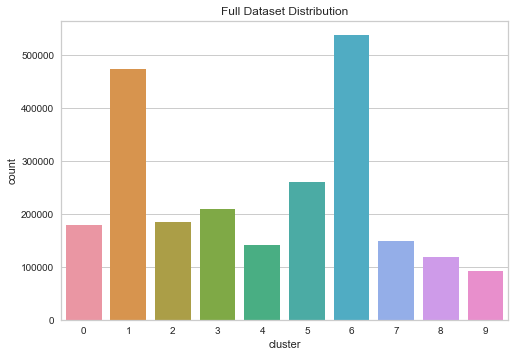

In [ ]:
sns.countplot(x=df3['cluster'])
plt.title("Full Dataset Distribution")


Text(0.5, 1.0, 'Labeled Dataset Distribution')

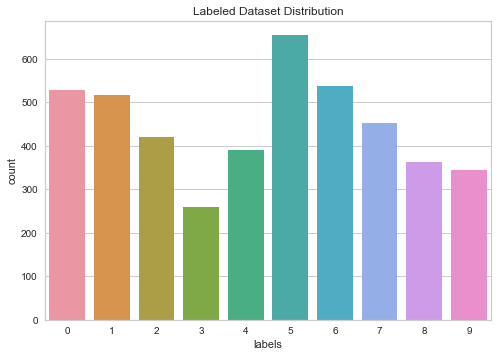

In [ ]:
sns.countplot(x=df['labels'])
plt.title("Labeled Dataset Distribution")


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4469 entries, 0 to 4468
Data columns (total 59 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id_mskd    4469 non-null   object 
 1   PCD_CDA             4469 non-null   float64
 2   PCD_CMS             4469 non-null   float64
 3   PCD_CRC             4469 non-null   float64
 4   PCD_LLC             4469 non-null   float64
 5   PCD_MOR             4469 non-null   float64
 6   PCD_MUF             4469 non-null   float64
 7   PCD_SAV             4469 non-null   float64
 8   PCD_SDB             4469 non-null   float64
 9   PCD_TED             4469 non-null   float64
 10  rating              4469 non-null   float64
 11  in_amt_sum          4469 non-null   float64
 12  in_cnt_sum          4469 non-null   float64
 13  out_amt_sum         4469 non-null   float64
 14  out_cnt_sum         4469 non-null   float64
 15  in_amt_avg          4469 non-null   float64
 16  in_cnt

In [ ]:
#create sliced dataframes for each cluster
cluster1_test=df_test[df_test["cluster"]==0].drop(columns=["cluster"])
cluster2_test=df_test[df_test["cluster"]==1].drop(columns=["cluster"])
cluster3_test=df_test[df_test["cluster"]==2].drop(columns=["cluster"])
cluster4_test=df_test[df_test["cluster"]==3].drop(columns=["cluster"])
cluster5_test=df_test[df_test["cluster"]==4].drop(columns=["cluster"])
cluster6_test=df_test[df_test["cluster"]==5].drop(columns=["cluster"])
cluster7_test=df_test[df_test["cluster"]==6].drop(columns=["cluster"])
cluster8_test=df_test[df_test["cluster"]==7].drop(columns=["cluster"])
cluster9_test=df_test[df_test["cluster"]==8].drop(columns=["cluster"])
#cluster10_test=df_test[df_test["cluster"]==9].drop(columns=["cluster"])
#cluster11_test=df_test[df_test["cluster"]==10].drop(columns=["cluster"])



In [ ]:

#Cluster 1
cluster1bestparam=[{'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}]

#Cluster 2
cluster2bestparam= [{'clf__C': 3, 'clf__kernel': 'rbf'}]

#Cluster 3
cluster3bestparam= [{'clf__C': 0.5, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}]

#Cluster 4
cluster4bestparam= [{'clf__C': 0.5, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}]

#Cluster 5
cluster5bestparam= [{'clf__n_neighbors': 20}]

#Cluster 6
cluster6bestparam= [{'clf__learning_rate': 1.0, 'clf__loss': 'deviance', 'clf__n_estimators': 300}]

#Cluster 7
cluster7bestparam= [ {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_impurity_decrease': 0.005, 
                      'clf__min_samples_split': 40}]
#Cluster 8
cluster8bestparam= [{'clf__C': 0.5, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}]

#Cluster 9
cluster9bestparam= [{'clf__learning_rate': 0.1, 'clf__loss': 'deviance', 'clf__n_estimators': 200}]

Cluster 10
cluster10bestparam= [{'clf__n_neighbors': [20]}]

#Cluster 11
#cluster11bestparam= [{'clf__n_neighbors': [20]}]



In [ ]:
#Run Each Model Using Grid Search with Optimial Parameters
cluster1_model = GridSearchCV(estimator=pipe_gbr,
			param_grid=cluster1bestparam,
			scoring='accuracy',
                    cv=10)

cluster2_model  = GridSearchCV(estimator=pipe_gbr,
			param_grid=cluster2bestparam,
			scoring='accuracy',
                    cv=10)

cluster3_model  = GridSearchCV(estimator=pipe_gbr,
			param_grid=cluster3bestparam,
			scoring='accuracy',
                    cv=10)

cluster4_model  = GridSearchCV(estimator=pipe_knn,
			param_grid=cluster4bestparam,
			scoring='accuracy',
                     cv=10)

cluster5_model  = GridSearchCV(estimator=pipe_knn,
			param_grid=cluster5bestparam,
			scoring='accuracy',
                     cv=10)

cluster6_model  = GridSearchCV(estimator=pipe_knn,
			param_grid=cluster6bestparam,
			scoring='accuracy',
                     cv=10)

cluster7_model  = GridSearchCV(estimator=pipe_knn,
			param_grid=cluster7bestparam,
			scoring='accuracy',
                     cv=10)

cluster8_model  = GridSearchCV(estimator=pipe_knn,
			param_grid=cluster8bestparam,
			scoring='accuracy',
                     cv=10)

cluster9_model  = GridSearchCV(estimator=pipe_knn,
			param_grid=cluster9bestparam,
			scoring='accuracy',
                     cv=10)

cluster10_model  = GridSearchCV(estimator=pipe_knn,
			param_grid=cluster10bestparam,
			scoring='accuracy',
                     cv=10)

cluster11_model  = GridSearchCV(estimator=pipe_knn,
			param_grid=cluster11bestparam,
			scoring='accuracy',
                     cv=10)



In [ ]:
cluster1_model.fit(xtrain_dict[0], ytrain_dict[0].values.ravel())

In [ ]:
cluster2_model.fit(xtrain_dict[1], ytrain_dict[1].values.ravel())

In [ ]:
cluster3_model.fit(xtrain_dict[2], ytrain_dict[2].values.ravel())

In [ ]:
cluster4_model.fit(xtrain_dict[3], ytrain_dict[3].values.ravel())

In [ ]:
cluster5_model.fit(xtrain_dict[4], ytrain_dict[4].values.ravel())

In [ ]:
cluster6_model.fit(xtrain_dict[5], ytrain_dict[5].values.ravel())

In [ ]:
cluster7_model.fit(xtrain_dict[6], ytrain_dict[6].values.ravel())

In [ ]:
cluster8_model.fit(xtrain_dict[7], ytrain_dict[7].values.ravel())

In [ ]:
cluster9_model.fit(xtrain_dict[8], ytrain_dict[8].values.ravel())

In [ ]:
cluster10_model.fit(xtrain_dict[9] ytrain_dict[9].values.ravel())

In [ ]:
cluster11_model.fit(xtrain_dict[10], ytrain_dict[10].values.ravel())

In [ ]:
#Predict Income from Test Data
test_pred1=cluster1_model.predict(cluster1_test)
test_pred2=cluster2_model.predict(cluster2_test)
test_pred3=cluster3_model.predict(cluster3_test)
test_pred4=cluster4_model.predict(cluster4_test)
test_pred5=cluster5_model.predict(cluster5_test)
test_pred6=cluster6_model.predict(cluster6_test)
test_pred7=cluster7_model.predict(cluster7_test)
test_pred8=cluster8_model.predict(cluster8_test)
test_pred9=cluster9_model.predict(cluster9_test)
test_pred10=cluster10_model.predict(cluster10_test)
test_pred11=cluster11_model.predict(cluster11_test)


In [ ]:
#Create series based of predictions
cluster1_test["predictions"]=test_pred1
cluster2_test["predictions"]=test_pred2
cluster3_test["predictions"]=test_pred3
cluster4_test["predictions"]=test_pred4
cluster5_test["predictions"]=test_pred5
cluster6_test["predictions"]=test_pred6
cluster7_test["predictions"]=test_pred7
cluster8_test["predictions"]=test_pred8
cluster9_test["predictions"]=test_pred9
cluster10_test["predictions"]=test_pred10
cluster11_test["predictions"]=test_pred11

In [ ]:
#create temporary predictions variables
df_test["predictions1"]=cluster1_test["predictions"]
df_test["predictions2"]=cluster2_test["predictions"]
df_test["predictions3"]=cluster3_test["predictions"]
df_test["predictions4"]=cluster4_test["predictions"]
df_test["predictions5"]=cluster5_test["predictions"]
df_test["predictions6"]=cluster6_test["predictions"]
df_test["predictions7"]=cluster7_test["predictions"]
df_test["predictions8"]=cluster8_test["predictions"]
df_test["predictions9"]=cluster9_test["predictions"]
df_test["predictions10"]=cluster10_test["predictions"]
df_test["predictions11"]=cluster11_test["predictions"]

In [ ]:
#fill null values with 0
df_test.fillna(0, inplace=True)

In [ ]:
#Create final prediction column
df_test['final_pred']=[]

In [ ]:
#Add all the columns up
#should only ad itself to 0 as null values were based on index numbers
df_test['final_pred']= df_test["predictions1"] + df_test["predictions2"]
+df_test["predictions3"] + df_test["predictions4"]+df_test["predictions5"]+df_test["predictions5"] +df_test["predictions5"] 
+df_test["predictions6"] +df_test["predictions7"] +df_test["predictions8"] +df_test["predictions9"]+df_test["predictions10"] 
+df_test["predictions11"] 

In [ ]:
final_pred=df_test["final_pred"]

In [ ]:
with open('Team7Predictions.txt', 'wb') as f:
    np.save(f, final_pred, allow_pickle=False)

In [ ]:
with open('Team7Predictions (2).txt', 'rb') as f:
    test_set_predictions = np.load(f)

In [ ]:
test_set_predictions